# Assignment 3: Kaggle Competition

Team: Puri and Ansari LLC.


## Intro and Imports

Here are the imports. We may not use all of them.

In [ ]:
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from google.colab import files
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pathlib
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras import models
import pandas as pd

from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

!pip install relieff
from ReliefF import ReliefF

import shap

!pip install lime
import lime
from lime import lime_tabular


## Obtain the Data (Google Colab)

Upload the zip file containing the data to the Drive part of your Google account. We'll be unzipping it and making a folder to access it.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/csci-e-82-2024.zip -d /content/unzipped/

Archive:  /content/drive/MyDrive/csci-e-82-2024.zip
  inflating: /content/unzipped/sample_solution.csv  
  inflating: /content/unzipped/test_data.csv  
  inflating: /content/unzipped/train_data.csv  


In [7]:
import os

# List files in the unzipped folder so that we have a path to read from
unzip_path = '/content/unzipped/'
for root, dirs, files in os.walk(unzip_path):
    for file in files:
        print(os.path.join(root, file))

/content/unzipped/sample_solution.csv
/content/unzipped/train_data.csv
/content/unzipped/test_data.csv


## Load and examine the data.

In [10]:
basic = pd.read_csv('/content/unzipped/train_data.csv')
basic.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,...,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,...,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,...,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,...,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,...,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


In [11]:
test = pd.read_csv('/content/unzipped/test_data.csv')
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,4.665949,0.083412,-17.397081,0.067865,0.005895,0.000012,...,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290,E,4,D
1,0,0,0,0,-398.299487,0.784032,-10.785768,403.784446,0.070405,0.000180,...,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017,H,4,D
2,0,0,0,1,-380.902140,0.671324,-9.265829,361.841929,0.006937,0.000025,...,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553,C,4,B
3,0,0,0,1,-342.784124,0.469414,-8.044287,293.043601,0.007217,-0.000021,...,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359,H,1,C
4,0,0,0,1,6.248502,0.252336,-5.398056,0.110097,0.005573,0.000010,...,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150,E,4,B


In [12]:
sol = pd.read_csv('/content/unzipped/sample_solution.csv')
sol.head()

,id,output
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [ ]:
print(basic.dtypes)

x1           int64
x2           int64
x3           int64
x4           int64
x5         float64
            ...   
z222       float64
subject     object
phase        int64
state       object
output       int64
Length: 670, dtype: object


In [ ]:
print(basic.shape)
print(test.shape)
print(sol.shape)

(4584, 670)
(1732, 669)
(1732, 2)


On an initial sweep of the data, we find the structure of data being a dataset that contains mostly floats, ints, and a case of two objects that we interpret to utilize as categorical variables. The training data is 4584 x 670 with one column as the output. Let's look a bit more closely at the data itself.

Our training data has about 11 different outcomes for "subject", 4 different outcomes for "phase" (though they are numeric so they may be impacted), 5 different outcomes for "state" and a binary outcome for "output".

In [ ]:
print(basic['subject'].value_counts())
print(basic['phase'].value_counts())
print(basic['state'].value_counts())
print(basic['output'].value_counts())

subject
I    663
G    518
B    513
K    468
L    444
D    420
A    380
C    361
F    330
M    306
H    181
Name: count, dtype: int64
phase
4    1291
1    1215
2    1063
3    1015
Name: count, dtype: int64
state
C    2106
B    1502
D     576
A     398
E       2
Name: count, dtype: int64
output
1    3873
0     711
Name: count, dtype: int64


We decided to label the "categorical" data (or datas we felt needed encoding / dummies) as the ones with object datatypes. This meant that our categorical columns would be our "subject" and "state" variables. The rest of the data would be treated as numerical data and treated mostly the same.

In [13]:
categorical_cols = basic.select_dtypes(include=['object', 'category']).columns
numerical_cols = basic.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: Index(['subject', 'state'], dtype='object')
Numerical Columns: Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       ...
       'z215', 'z216', 'z217', 'z218', 'z219', 'z220', 'z221', 'z222', 'phase',
       'output'],
      dtype='object', length=668)


## How are we going to predict the outputs?

There are a few methods we have in mind.


### Plan / Hypothesis: **RandomForestRegressor**

We will utilize a Random Forest machine learning algorithm and consider it a baseline for how we wish to proceed.

The primary reason we elect to utilize sklearn's RandomForestRegressor over RandomForestClassifier is because of the way the output is provided. RandomForestClassifier provides its outputs or predictions as discrete labels (i.e. 0, 1) as opposed to RandomForestRegressor, which provides its outputs as continuous probability scores. As we were informed that this is an acceptable form of output, we will utilize RandomForestRegressor for its probability measures.

In addition to utilizing, the full dataset, we will also utilize Feature Selection using ReliefF to find the most important features and use those to construct a model as well for predicting the test data.


---



### Plan / Hypothesis: **Feedforward Neural Networks**

A neural network will capture non-linear relationships between the (many) variables we have and the target output we have for our training and, eventually, test data.

It can also do well at capturing the interactions between the many features, it has customizable architecture to allow us to make it more or less complex as well as introduce regularizers. It is a very modular means of developing different models.

We will introduce more means of modulating the neural network as they become necessary to improve our model.

#### What is kept constant?

For the neural networks, we'll be keeping a few factors constant unless otherwise stated.







*   We'll keep to 3 hidden layers unless otherwise stated.

*   Loss function of binary crossentropy for training binary classification model.

*   **Dropout**: we'll be keeping the dropout probability as 0.3 if there is a dropout layer. Inclusion may be arbitrary or chosen as part of testing.

*   **Optimizer**: unless otherwise stated, we'll be utilizing the default optimizer of 'adam'. ADAM handles sparse data, like one-hot encoded data, well. It also adjust learning rates and can provide faster convergences. Another potential good optimizer is SGD.


*   **Regularizer types**: we'll be utilizing L1 (lasso regression) and elastic net (L1 and L2) regularizers. There are over 600 features and there's bound to be ones that aren't helpful - lasso regression will 0 out the least useful ones and maintain the most relevant ones, which is relevant to our aim of feature selection. Elastic net incorporates this approach with L2's (ridge regression) aim of reducing overfitting and limiting multicollinearity.

*   **Activation**: unless otherwise stated, we'll be utilizing the activation function of 'ReLu' - rectified linear activation, with a 'sigmoid' activation. The sigmoid activation function will present an output of 0 or 1. ReLu activation helps keep the model efficient and running quickly even when the gradients become extremely small deeper in the architecture. In addition, ReLU outputs 0 for negative inputs, which introduces sparsity in the network (only some neurons are active), making it more efficient. Finally, ReLu is good for non-linear relationship modeling.




## Encoding For Modeling - First Attempt

### **Plan / Hypothesis**: Encoding - Label encoding

We're going to explore RandomForestRegressors and NeuralNetworks with Label Encoding for our "categorical data".



---



We considered between two methods of preprocessing / encoding the data from the categorical columns (i.e. 'subject', 'state') into numerical data we could input into the machine learning models - One-hot encoding and label encoding.

Because one-hot encoding would add additional features / columns to our data, we elected to utilize a LabelEncoder for the purpose of simplicity when encoding the data and to limit the ensuing dimensionality of our data.

In [14]:
from sklearn.preprocessing import LabelEncoder

# Make additional copy that we can modify
basic2 = basic.copy()
# Label encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    basic2[col] = le.fit_transform(basic2[col])

print(basic2[categorical_cols].head())

   subject  state
0        8      2
1        0      2
2        3      2
3        5      2
4        2      2


In [15]:
# Label encoding the test data

test2 = test.copy()
for col in categorical_cols:
    le = LabelEncoder()
    test2[col] = le.fit_transform(test2[col])

print(test2[categorical_cols].head())

   subject  state
0        4      3
1        7      3
2        2      1
3        7      2
4        4      1


Now we have 2 DataFrames we can use that have been label encoded: **basic2** and **test2**.

### Brief Interpretation: Label encoding flaw



---



We elected to "fit_transform" over transforming because of an error that ensued - the transform function wouldn't proceed as the column, 'subject' had other values that couldn't be transformed properly from the original encoder.

In practice, this was simultaneously a syntactic mistake we overlooked and, in hindsight, this was a flaw in our work and would limit our results. This would continue to halt our results as we could not properly label encode our data. Our results may have improved had we mapped the unseen data to a different, custom category but we didn't realize this at the time.

In [ ]:
# Shown with label encoding
test2

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,4.665949,0.083412,-17.397081,0.067865,0.005895,0.000012,...,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290,4,4,3
1,0,0,0,0,-398.299487,0.784032,-10.785768,403.784446,0.070405,0.000180,...,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017,7,4,3
2,0,0,0,1,-380.902140,0.671324,-9.265829,361.841929,0.006937,0.000025,...,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553,2,4,1
3,0,0,0,1,-342.784124,0.469414,-8.044287,293.043601,0.007217,-0.000021,...,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359,7,1,2
4,0,0,0,1,6.248502,0.252336,-5.398056,0.110097,0.005573,0.000010,...,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,0,0,0,1,7.056794,0.110144,-12.775892,0.137674,0.005864,0.000018,...,-0.005090,-0.008595,0.011176,58.483335,156.676165,138.921456,40.727735,4,4,0
1728,0,0,0,0,-368.268196,2.177478,-3.228319,338.839496,0.017237,-0.000162,...,-0.035026,-0.012728,-0.072135,-6.861969,6.204253,-1.811345,0.170753,9,1,1
1729,0,0,0,0,-352.362181,0.943715,-5.737531,311.017007,0.028563,0.000051,...,0.039992,0.009640,0.018138,-3.580142,5.214474,-2.619610,0.450454,9,1,3
1730,0,0,0,1,-148.320872,2.755825,-1.454114,55.099923,0.010104,-0.000100,...,-0.055467,-0.017678,-0.005935,-74.888894,209.678861,-195.942319,61.117414,9,4,2


These following variables, **X and y** are going to be used by the RandomForestRegressor as well as the feedforward neural networks. They have the label encoded data.

In [16]:
# Preparing the data to be used by the RandomForestRegressor and other models.

X = basic2.drop(columns=['output'])  # Drop the output/target column

y = basic2['output']  # Define the target variable


## ReliefF Feature Selection

**Why did we select Relief?**



Below are the top 125 features we'll use to train, importance of fearures seems to be dropping after that. The reason to choose Relief family of algorithms is explained in more detail within summary document. But gist of it is, ReliefF tends to handle large noisy data set which includes both continuous and categorical data. It also tends to perform better with class imbalance which is the case with our data when ~84% of target labels belong to one class.

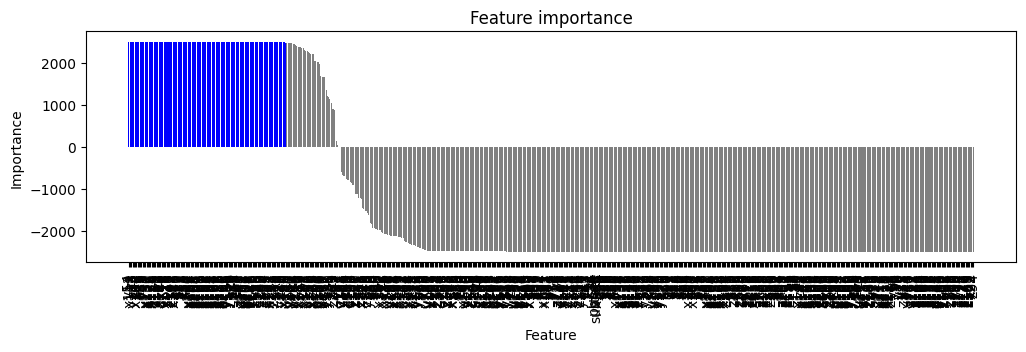

In [32]:
# selecting significant features using Relief Model

fs = ReliefF(n_neighbors=1, n_features_to_keep=125) # n_neighbors is the number of times to iterate through the ReliefF algorithm

X_train = fs.fit_transform(X.values, y)

feature_names = [X.columns[idx] for idx in fs.top_features]
feature_to_list = sorted(list(zip(feature_names, fs.feature_scores)), key=lambda x: x[1], reverse=True)
sorted_df = pd.DataFrame(feature_to_list, columns=["feature", "importance"])

# Features above the best performing shadow feature are the ones we want to keep
colors = ['blue' if idx < fs.n_features_to_keep else 'gray' for idx in range(len(sorted_df))]

plt.figure(figsize=(12, 3))
plt.bar(sorted_df["feature"], sorted_df["importance"], color=colors)
plt.xticks(rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance")
plt.show()

In [ ]:
print(sorted_df['feature'].iloc[0:125])

0       y54
1      x112
2        z3
3      y113
4       z93
       ... 
120    y222
121     z40
122     y40
123    x191
124    x190
Name: feature, Length: 125, dtype: object


In [33]:
use_features=sorted_df['feature'].iloc[0:125].tolist()
print(type(use_features))

<class 'list'>


In [ ]:
use_features

### Brief Interpretation: Features

There were about 166 features with a positive value for importance in the data of our original 669 features. Only the first 125 features in our sorted dataframe had importance values of about 2500, meaning they had the highest discriminative power. Those variables were very influential in distinguishing between the two target classes.

Yet, something I noted was that the ReliefF model did not consider the the categorical variables 'subject' and 'state' as relatively important. This may have been a sign we overlooked about the flaws in our preprocessing or in how Relief evaluated them; alternatively, it might have also meant that those variables weren't necessarily as important as we'd previously thought. When we looked closer, those variables had negative importance scores meaning they may have been impeding the predictive capability of the model.

High importance scores may have also meant that there some issues with scaling as there may have been plenty of outliers in the data we elected to simply scale.

We didn't have very many clear takeaways but it was clear that at least these 125 features were very good at predicting the output according the Relief feature selection algorithm.



## RandomForest - Attempts with Full Data and Feature Selection

## SHAP and LIME Methods
We'll use these methods to get insight in different model as we go through them.

In [ ]:
# reference from section 6
import shap

def plot_shap_summary(model_to_plot, x_train, x_test, downsample):
  explainer = shap.KernelExplainer(model_to_plot.predict, shap.sample(x_train,downsample))
  shap_values = explainer(shap.sample(x_test,downsample))
  shap.summary_plot(shap_values, shap.sample(x_test,downsample))

In [ ]:
# method to plot LIME analysis

def plot_lime_explainer(model, x_train, index_of_event):

  predict_fn = lambda x: model.predict_proba(x)
  explainer = lime.lime_tabular.LimeTabularExplainer(x_train.astype(int).values,
                                                     mode='classification',
                                                     class_names=['0', '1'],
                                                     training_labels=basic['output'],
                                                     feature_names=x_train.columns)
  # using LIME to get the explanations
  i = 5
  exp=explainer.explain_instance(x_train.loc[index_of_event, x_train.columns].astype(int).values, predict_fn, num_features=5)

  # Visualize the explanation
  exp.show_in_notebook(show_table=True, show_all=False)

### RandomForestRegressor - Full data

Here we are executing the code to split our full training data into training and validation sets.

In [20]:
from sklearn.model_selection import train_test_split
import time

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



Here we are executing the code that instantiates and starts training a RandomForestRegressor model. We also keep track of how much time it takes for comparison.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Train a RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

start = time.time()

model.fit(X_train, y_train)
print(f'Time: {time.time() - start}')


Training set shape: (3667, 669)
Validation set shape: (917, 669)
Time: 333.52705335617065


Let's try to SHAP summary for this trained model

  0%|          | 0/50 [00:00<?, ?it/s]

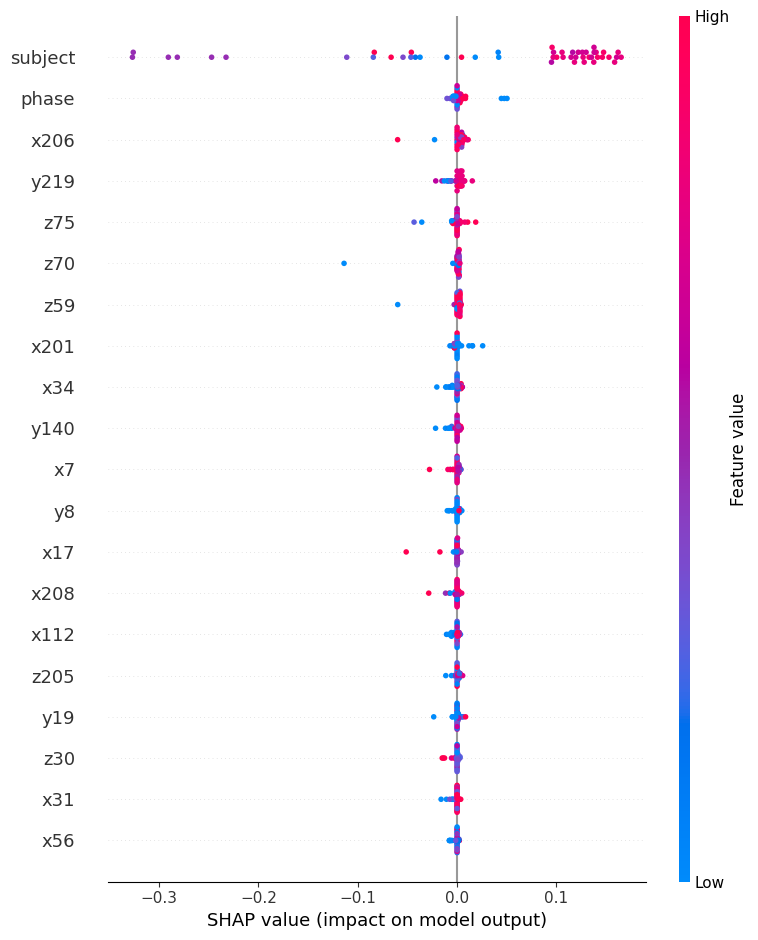

In [ ]:
plot_shap_summary(model, X_train, X_val, 50)

As per the plot above, surprisingly two of the few categorical features "subject" & "phase" tend to have most influence on model prediction in this case as opposed to the result we obtained from the prior ReliefF graph. Taking "subject" for example, it's strongly affecting (mostly red/pink) predictions positively. “X201” on the other hand, had lower significance but also pushed the prediction to positive direction.

Now let's try LIME plot

In [ ]:
plot_lime_explainer(model, X_train, 1)

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

Apparently LIME isn't compatible with a Model without prabability scores such as RandomForestRegressor we used above

Here we check the model's ability to predict the results of unseen data  using the validation set.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Evaluate the model

mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {mse}")
print(f"Validation R²: {r2}")

Validation MSE: 0.09425136314067611
Validation R²: 0.30363288141847966


#### Brief Interpretation of results

We have a relatively low MSE, which is good. There's not a very high difference between the actual and predicted values.

But our validation R^2 is very low - we're only capturing about 30% of the variance in the output via the model. The model has captured some of the patterns but not enough.

There is room for improvement with this model. Perhaps a RandomForestRegressor isn't a good model at all for this. Furthermore, it took a while to fit the model. Let's see if the model may get better or worse by limiting the less useful features.




---

### RandomForestRegressor - ReliefF Feature Selection

We are limiting the features we use to the top 125 importance identified by the ReliefF model.



---


Here we make a train-validation split of our data once again but limited to the selected feature data.

In [62]:
# Feature Selection Version

from sklearn.model_selection import train_test_split
import time

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X[use_features], y, test_size=0.2, random_state=42)



Once again, we instantiate and train a RandomForestRegressor. But this time, we use a subset of the dataset - the most important features - for use with the validation data.

In [ ]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


model = RandomForestRegressor(n_estimators=100, random_state=42)

start = time.time()

model.fit(X_train, y_train)
print(f'Time: {time.time() - start}')

Training set shape: (3667, 125)
Validation set shape: (917, 125)
Time: 42.616443157196045


Here we check the model's ability to predict the results of unseen data again using the validation set.

In [ ]:
val_predictions = model.predict(X_val)

mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {mse}")
print(f"Validation R²: {r2}")

Validation MSE: 0.11787600872410033
Validation R²: 0.12908446297402743


#### Brief Interpretation of Results

Time taken to fit the model decreased by almost 6x. However, the model's capability has decreased massively compared to before. The MSE has increased from about 0.094 to 0.118. The error has gone up.

In addition, the validation R^2 has decreased from 0.303 to 0.129. The model with the most relevant features is now explaining only about 13% of the variance in the output.

It does not seem as though keeping the most relevant features is working well with RandomForestRegressor nor is this model the best option.

We'll move on to neural networks.

## Scaling the Data - First Attempt (Only StandardScaler)

We'll use sigmoid output for a neural network since our outputs are only 0 or 1.



---

First, we'll scale the numerical data to prepare it for the neural networks. This may or may not be a good idea, given that StandardScaler assumes the values are normally distributed and given that we have some categorical data that was converted to numerical data via label encoding. For now, we'll run with this for our example / practice.

Here is the code where we scale the training, validation and test data with a StandardScaler.

In [45]:
from sklearn.preprocessing import StandardScaler

# Remake the training and validation data with full dataset

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the data

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val2 = scaler.transform(X_val)  # Only transform validation data (no fitting)

In [47]:
X_test_scaled = scaler.transform(test2)

## Define plotting methods

We will make a few methods to speed up plotting our models' accuracy and loss as well as getting validation records + confusion matrixes to evaluate how our validation set predictions look for a better idea at how the model is predicting outputs.

In [27]:
# Plot the accuracy and validation accuracy, given a history for a model's training
def plot_acc(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# Plot the loss and the validation loss, given a history for a model's training
def plot_loss(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.show()

In [28]:
# Evaluate the model on the validation set

def val_report(model, x_val, y_val):

  val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)

  print(f"Validation Loss: {val_loss}")
  print(f"Validation Accuracy: {val_accuracy}")

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

# Make predictions using the model with the validation data and then
# convert those into integer outputs / labels for usage with
# a confusion matrix. Compare these predictions to the true answers
# Make a confusion matrix with the results

def confusion_graph(model, x_val, y_val):

  predictions = model.predict(x_val)
  final_class_labels = (predictions > 0.5).astype(int)
  pred = pd.DataFrame(final_class_labels)

  cm = confusion_matrix(pred, y_val)

  print(classification_report(y_val, pred))


  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

## Feedforward Neural Network without Feature Selection - First, Second, Third Attempts

Let's keep track of our variables for now:

**X_train2**: the StandardScaled training data.

**X_val2**: the StandardScaled validation data.

**X_test_scaled**: the StandardScaled test data.

In [ ]:
X_train2.shape

(3667, 669)

### Basic Feedforward Neural Network

What do we need to consider for modulating our Neural networks?



*   Optimizers (e.g. Adam)
*   Regularizers (e.g. Dropout, L1, L2, ElasticNet)
*   Complexity (e.g. layers and quantity)
*   Activation and Loss functions






Here we execute creating and compiling the new neural network. It has 'relu' activation for the input and hidden layers and has a 'sigmoid' activation for the output.

In [ ]:
# Make a feedforward neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model1 = Sequential()

model1.add(Dense(256, input_shape=(X_train2.shape[1],)))
model1.add(Activation('relu'))

model1.add(Dense(128))
model1.add(Activation('relu'))


model1.add(Dense(64))
model1.add(Activation('relu'))


model1.add(Dense(1, activation='sigmoid'))  # Single unit with sigmoid activation

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model1.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,737 (831.00 KB)

 Trainable params: 212,737 (831.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the callback - when val acc stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model1.fit(
    X_train2, y_train,
    validation_data=(X_val2, y_val),
    epochs=100,  # Max epochs
    batch_size=32,  # Adjust batch size as needed
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8444 - loss: 0.4552 - val_accuracy: 0.8386 - val_loss: 0.4376
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8590 - loss: 0.3665 - val_accuracy: 0.8375 - val_loss: 0.4070
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8421 - loss: 0.3541 - val_accuracy: 0.8408 - val_loss: 0.4158
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8824 - loss: 0.2887 - val_accuracy: 0.8386 - val_loss: 0.4520
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8917 - loss: 0.2639 - val_accuracy: 0.8430 - val_loss: 0.4605
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9075 - loss: 0.2312 - val_accuracy: 0.8266 - val_loss: 0.5458
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9052 - loss: 0.2181 - val_accuracy: 0.8277 - val_loss: 0.5274
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9347 - loss: 0.1716 - val_accu

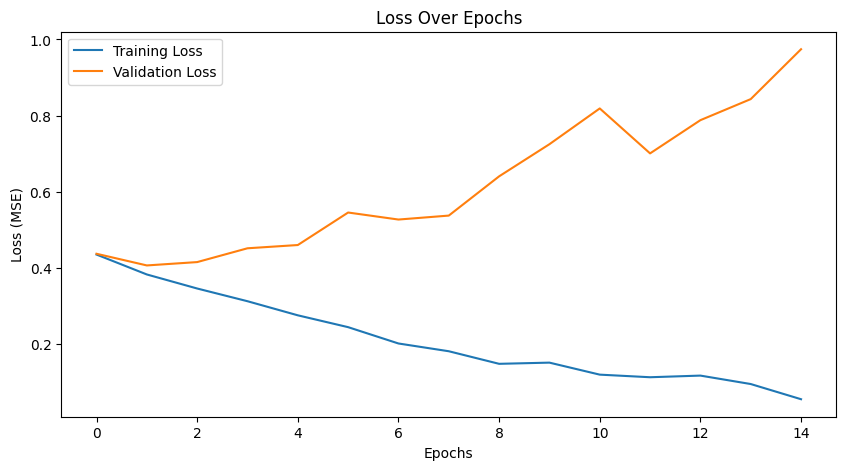

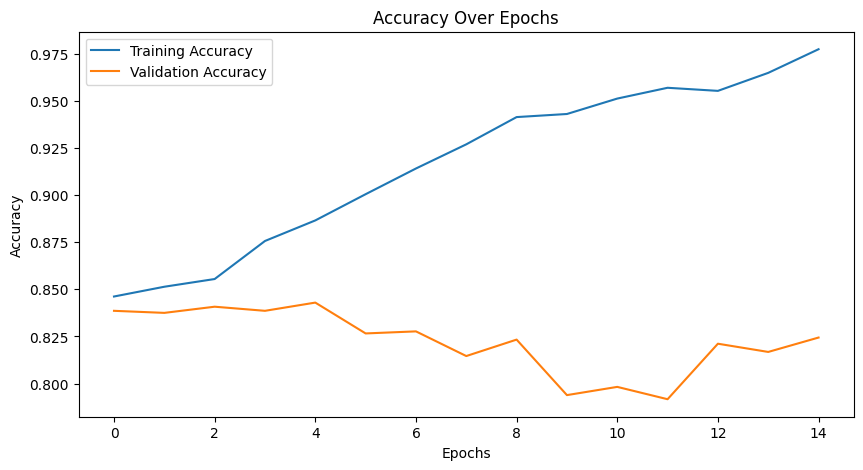

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model1.evaluate(X_val2, y_val, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.4592
Validation Loss: 0.4817739427089691
Validation Accuracy: 0.8418756723403931


In [ ]:
y_val.value_counts()

,count
output,
1,769
0,148


In [ ]:
769/(769+148)

0.8386041439476554

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.59      0.07      0.12       148
           1       0.85      0.99      0.91       769

    accuracy                           0.84       917
   macro avg       0.72      0.53      0.52       917
weighted avg       0.80      0.84      0.79       917



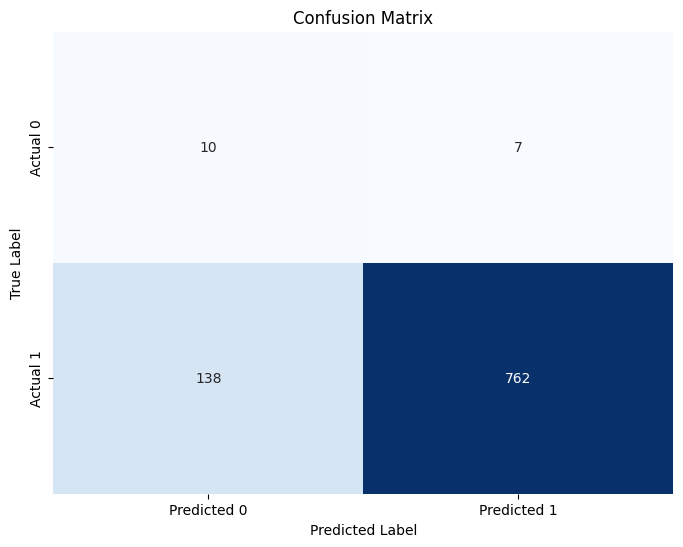

In [ ]:
import seaborn as sns

confusion_graph(model1, X_val2, y_val)

#### Brief Interpretation: Plots


The validation accuracy seems to be decreasing. The validation loss is just constantly increasing. The model is overfitting and it doesn't seem to be capable of properly predicting the output. Could do with more regularizers or optimization.

Confusion matrix shows its not predicting many 0 labels well while predicting a lot of 1s.


---



### Basic Feedforward Neural Network with Feature Selection

In [42]:
# 125 features used
X_train, X_val, y_train2, y_val2 = train_test_split(X[use_features], y, test_size=0.2, random_state=42)


# Scale the data

scaler = StandardScaler()
X_train3 = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val3 = scaler.transform(X_val)  # Only transform validation data (no fitting)

In [ ]:
from tensorflow.keras.optimizers import AdamW


model1 = Sequential()

model1.add(Dense(256, input_shape=(X_train3.shape[1],)))
model1.add(Activation('relu'))

model1.add(Dense(128))
model1.add(Activation('relu'))


model1.add(Dense(64))
model1.add(Activation('relu'))


model1.add(Dense(1, activation='sigmoid'))  # Single unit with sigmoid activation

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model1.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │          32,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

We include an Early Stopping callback to help us utilize the best attempt that we get for our neural network in order to obtain the best possible results - we focus on Validation Accuracy.

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model1.fit(
    X_train3, y_train2,
    validation_data=(X_val3, y_val2),
    epochs=100,  # Max epochs
    batch_size=32,  # Adjust batch size as needed
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8384 - loss: 0.4693 - val_accuracy: 0.8386 - val_loss: 0.4120
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8420 - loss: 0.4152 - val_accuracy: 0.8397 - val_loss: 0.4054
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8437 - loss: 0.3874 - val_accuracy: 0.8397 - val_loss: 0.4021
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8543 - loss: 0.3572 - val_accuracy: 0.8419 - val_loss: 0.4335
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8548 - loss: 0.3665 - val_accuracy: 0.8506 - val_loss: 0.4055
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8653 - loss: 0.3374 - val_accuracy: 0.8386 - val_loss: 0.4330
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8722 - loss: 0.3149 - val_accuracy: 0.8342 - val_loss: 0.4112
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8826 - loss: 0.2923 - val_acc

Let's try waht SHAP and LIME has to say about this FNN with feature selection

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


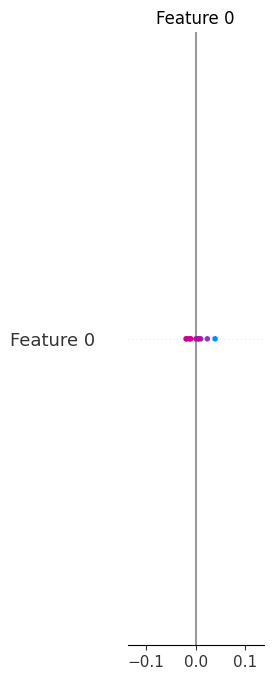

In [ ]:
plot_shap_summary(model1, X_train3, X_val3, 10)

Apparently SHAP doesn't get along with Scaled data.

In [ ]:
plot_lime_explainer(model1, X_train, 1)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

Unfortunately even with FNN, there isn't any ready method for probabilty score for classes.

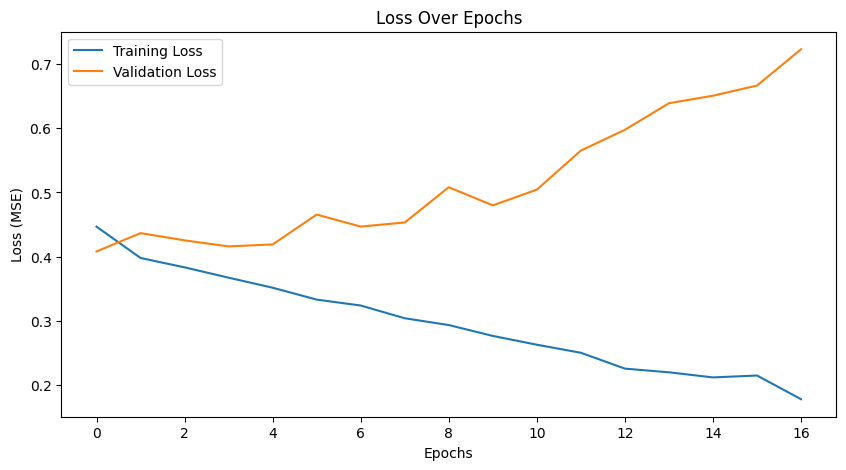

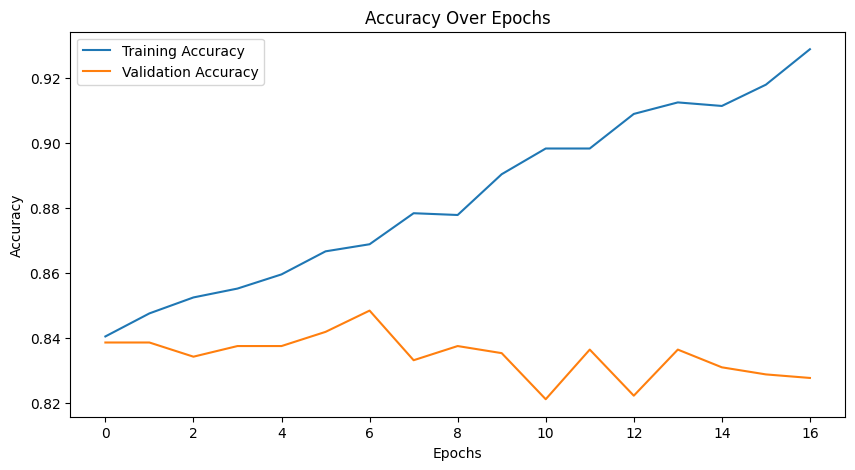

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
val_report(model1, X_val3, y_val2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.4206
Validation Loss: 0.4468386471271515
Validation Accuracy: 0.8484187722206116


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.63      0.15      0.24       148
           1       0.86      0.98      0.92       769

    accuracy                           0.85       917
   macro avg       0.74      0.57      0.58       917
weighted avg       0.82      0.85      0.81       917



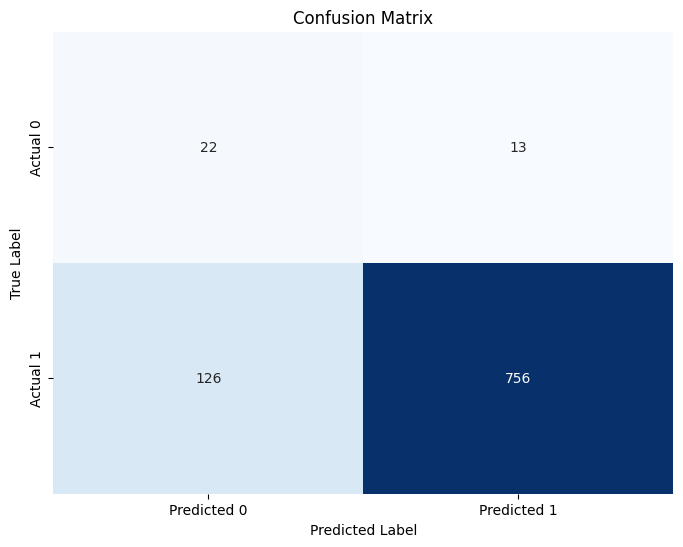

In [ ]:
confusion_graph(model1, X_val3, y_val2)

#### Brief Interpretation: Plots

Similar to before, the validation accuracy seems to be decreasing over training. The validation loss is constantly increasing. The model is overfitting and it doesn't seem to be capable of properly predicting the output. Could do with more regularizers or optimization. The validation accuracy is slightly higher than before - 0.848 compared to 0.841.

Confusion matrix shows its not predicting many 0 labels well while predicting a lot of 1s.


---



### BatchNormalization and Dropout (Full, Feature Selection)

Here we try it with a more complex neural network - 1 input, 3 hidden layers, batch normalization and dropout layers.

**Why are we using BatchNormalization?** To helps stabilize and speed up the training process. It'll help enable the model to converge faster and helps limit overfitting in the model by introducing noise when normalizing based on mini-batches. Ultimately, its something we're including for better performance.



#### BatchNormalization Only - Full Features

We utilize X_train2 and X_val2, y_train, and y_val here.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Input Layer + First Hidden Layer
model.add(Dense(256, input_shape=(X_train2.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Second Hidden Layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Third Hidden Layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output Layer (for binary classification)
model.add(Dense(1, activation='sigmoid'))  # Single unit with sigmoid activation

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,529 (838.00 KB)

 Trainable params: 213,633 (834.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Train the model
history = model.fit(
    X_train2, y_train,
    validation_data=(X_val2, y_val),
    epochs=100,  # Max epochs
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6082 - loss: 0.6792 - val_accuracy: 0.8397 - val_loss: 0.4497
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8587 - loss: 0.3702 - val_accuracy: 0.8222 - val_loss: 0.4179
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8589 - loss: 0.3433 - val_accuracy: 0.8386 - val_loss: 0.4042
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8660 - loss: 0.3374 - val_accuracy: 0.8266 - val_loss: 0.4131
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8645 - loss: 0.3193 - val_accuracy: 0.8332 - val_loss: 0.4431
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8798 - loss: 0.2932 - val_accuracy: 0.8092 - val_loss: 0.4314
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8900 - loss: 0.2679 - val_accuracy: 0.8353 - val_loss: 0.4411
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9006 - loss: 0.2509 - 

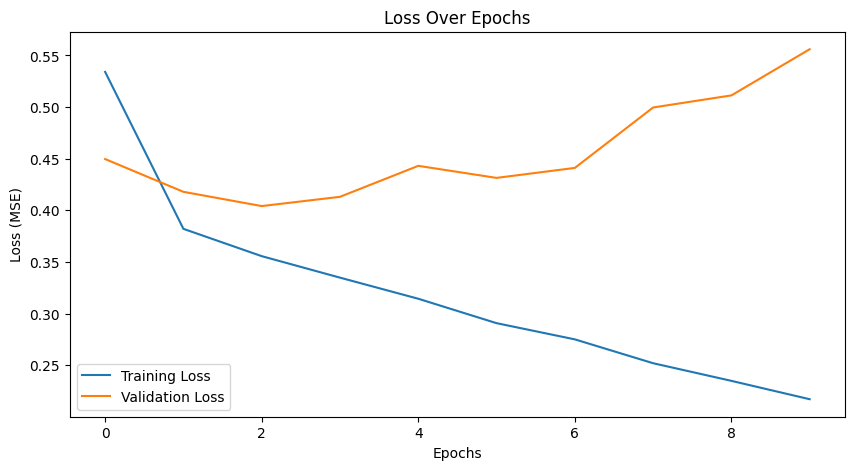

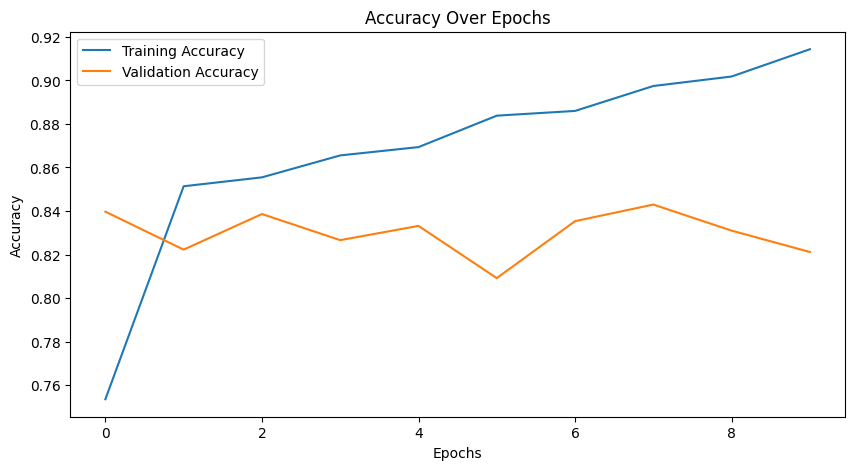

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8610 - loss: 0.4193
Validation Loss: 0.44967564940452576
Validation Accuracy: 0.8396946787834167
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.56      0.03      0.06       148
           1       0.84      0.99      0.91       769

    accuracy                           0.84       917
   macro avg       0.70      0.51      0.49       917
weighted avg       0.80      0.84      0.78       917



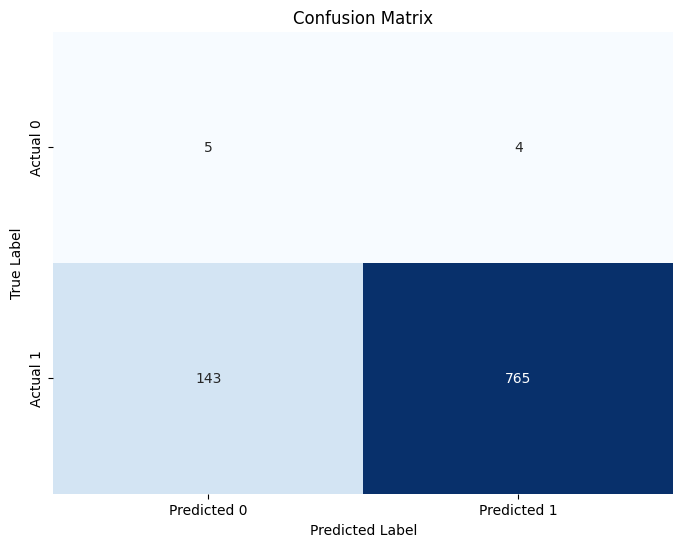

In [ ]:
plot_loss(history)
plot_acc(history)
val_report(model, X_val2, y_val)
confusion_graph(model, X_val2, y_val)

#### BatchNormalization Only - Feature Selection

We are using X_train3, X_val3, y_train2, y_val2

In [ ]:
y_train2.shape

(3667,)

In [ ]:
model = Sequential()

model.add(Dense(256, input_shape=(X_train3.shape[1],)))  # Input shape matches feature count
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                     │ (None, 256)                 │          32,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,265 (294.00 KB)

 Trainable params: 74,369 (290.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(
    X_train3, y_train2,
    validation_data=(X_val3, y_val2),
    epochs=100,  # Max epochs
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.7954 - loss: 0.4855 - val_accuracy: 0.8451 - val_loss: 0.4160
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8457 - loss: 0.4018 - val_accuracy: 0.8441 - val_loss: 0.4017
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8521 - loss: 0.3738 - val_accuracy: 0.8408 - val_loss: 0.4067
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8557 - loss: 0.3606 - val_accuracy: 0.8430 - val_loss: 0.4257
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8577 - loss: 0.3573 - val_accuracy: 0.8408 - val_loss: 0.4065
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8660 - loss: 0.3429 - val_accuracy: 0.8386 - val_loss: 0.4226
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8523 - loss: 0.3556 - val_accuracy: 0.8364 - val_loss: 0.4365
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8634 - loss: 0.3231 - val

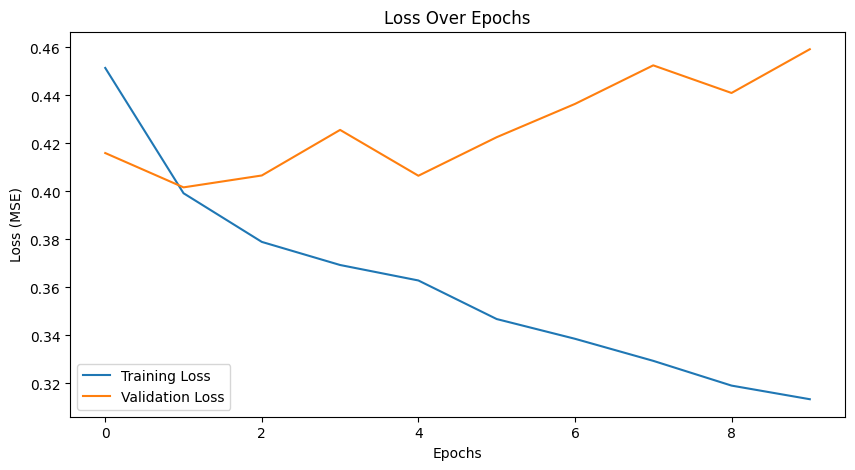

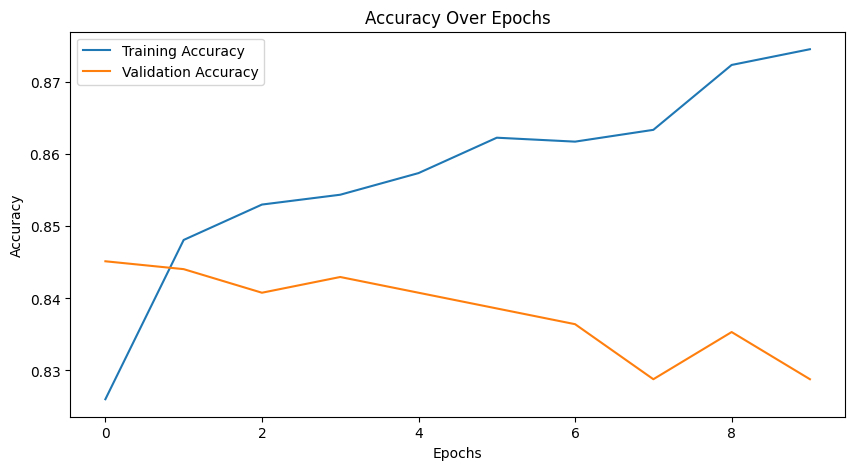

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8644 - loss: 0.3948
Validation Loss: 0.4160098433494568
Validation Accuracy: 0.8451471924781799
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       148
           1       0.84      1.00      0.92       769

    accuracy                           0.85       917
   macro avg       0.92      0.52      0.50       917
weighted avg       0.87      0.85      0.78       917



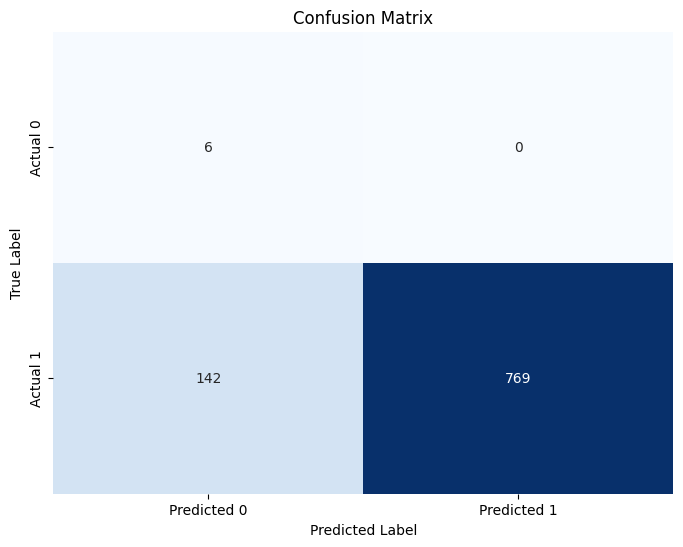

In [ ]:
plot_loss(history)
plot_acc(history)
val_report(model, X_val3, y_val2)
confusion_graph(model, X_val3, y_val2)

#### Brief Interpretation - BatchNormalization Only

In both cases (Full features, Feature selection), the models are struggling immensely with overfitting. Loss and accuracy are sporadic and going the opposite directions from where the training loss and accuracy go. The models need further improvement to deal with overfitting and improve learning.

In addition, both models are predicting hardly any 0s. Yet, the feature selection model has a higher validation accuracy of about 0.845 compared to the full feature model having a validation accuracy of about 0.839.

Let us try to reduce overfitting by adding dropout layers.

#### BatchNormalization with Dropout - Full Features

We are settling on a dropout value of 0.3 and including a dropout layer with each hidden layer. We are using X_train2, X_val2, y_train, y_val.

In [54]:
from sklearn.preprocessing import StandardScaler

# Remake the training and validation data with full dataset

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the data

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val2 = scaler.transform(X_val)  # Only transform validation data (no fitting)
X_test_scaled = scaler.transform(test2)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam


model2 = Sequential()

model2.add(Dense(256, input_shape=(X_train2.shape[1],)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.3))  # Dropout for regularization

model2.add(Dense(128))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(64))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(1, activation='sigmoid'))


model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,529 (838.00 KB)

 Trainable params: 213,633 (834.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model2.fit(
    X_train2, y_train,
    validation_data=(X_val2, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5750 - loss: 0.7149 - val_accuracy: 0.8332 - val_loss: 0.4522
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8390 - loss: 0.4429 - val_accuracy: 0.8462 - val_loss: 0.4108
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8502 - loss: 0.4116 - val_accuracy: 0.8495 - val_loss: 0.4040
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8436 - loss: 0.4159 - val_accuracy: 0.8451 - val_loss: 0.3953
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8530 - loss: 0.3832 - val_accuracy: 0.8473 - val_loss: 0.3925
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8375 - loss: 0.4048 - val_accuracy: 0.8441 - val_loss: 0.3861
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8407 - loss: 0.3901 - val_accuracy: 0.8441 - val_loss: 0.3997
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8478 - loss: 0.3776 - val_a

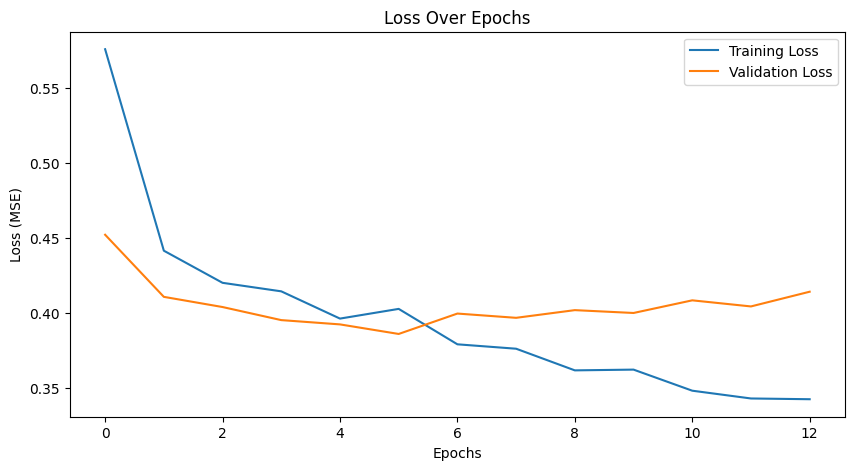

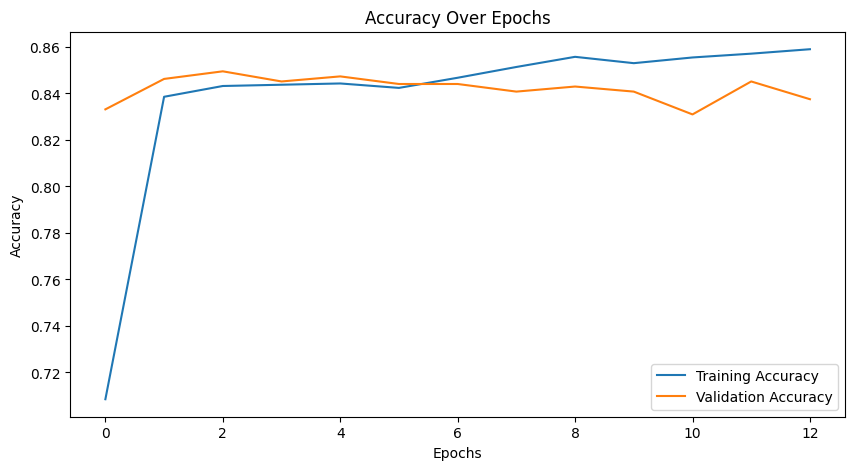

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.3802
Validation Loss: 0.40403321385383606
Validation Accuracy: 0.8495092988014221
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.81      0.09      0.16       148
           1       0.85      1.00      0.92       769

    accuracy                           0.85       917
   macro avg       0.83      0.54      0.54       917
weighted avg       0.84      0.85      0.79       917



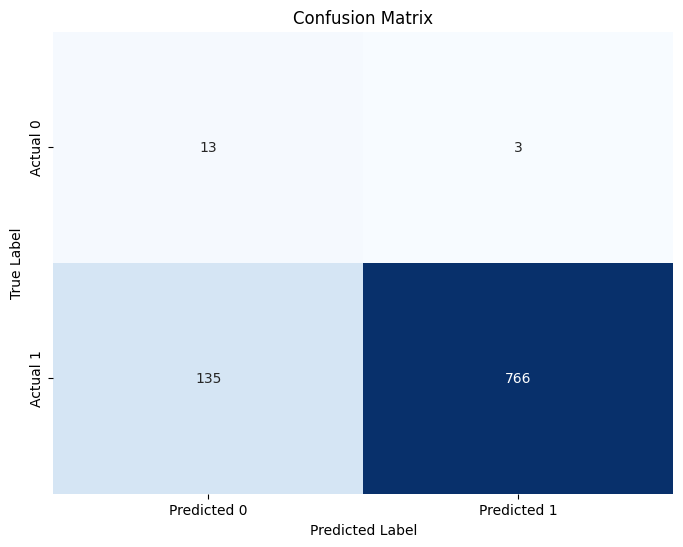

In [57]:
plot_loss(history)
plot_acc(history)
val_report(model2, X_val2, y_val)
confusion_graph(model2, X_val2, y_val)

#### BatchNormalization with Dropout - Feature Selection

We are using X_train3, X_val3, y_train2, y_val2

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam


model = Sequential()

model.add(Dense(256, input_shape=(X_train3.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │          32,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,265 (294.00 KB)

 Trainable params: 74,369 (290.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [36]:
history = model.fit(
    X_train3, y_train2,
    validation_data=(X_val3, y_val2),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7651 - loss: 0.5324 - val_accuracy: 0.8397 - val_loss: 0.4469
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8380 - loss: 0.4505 - val_accuracy: 0.8430 - val_loss: 0.4158
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8394 - loss: 0.4252 - val_accuracy: 0.8386 - val_loss: 0.4091
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8485 - loss: 0.4213 - val_accuracy: 0.8408 - val_loss: 0.4059
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8435 - loss: 0.4084 - val_accuracy: 0.8419 - val_loss: 0.4032
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8444 - loss: 0.4050 - val_accuracy: 0.8408 - val_loss: 0.4013
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8484 - loss: 0.4043 - val_accuracy: 0.8408 - val_loss: 0.3994
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8394 - loss: 0.4102 - val_accu

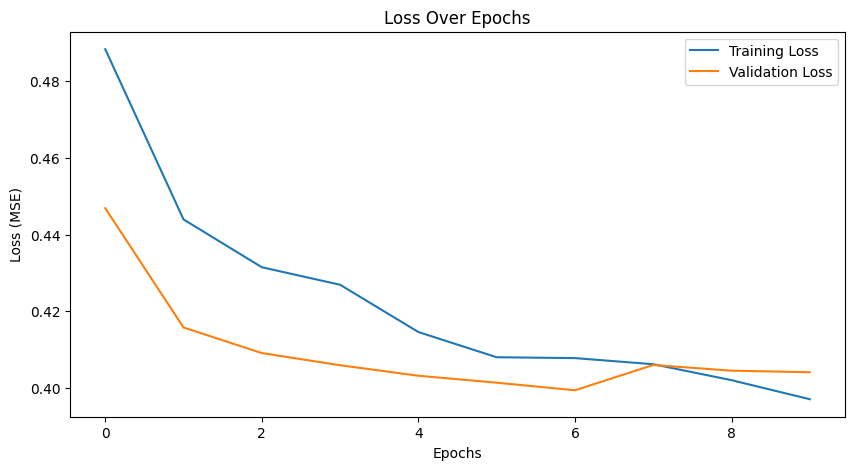

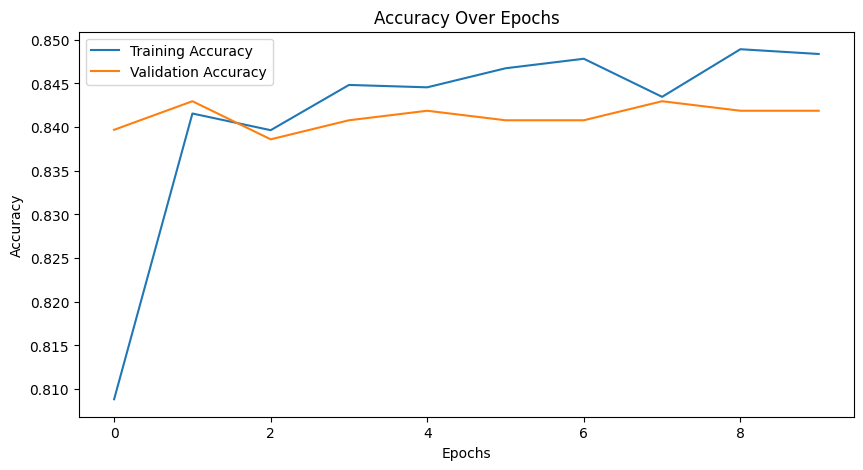

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.4299 
Validation Loss: 0.446892112493515
Validation Accuracy: 0.8396946787834167
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       148
           1       0.84      1.00      0.91       769

    accuracy                           0.84       917
   macro avg       0.92      0.50      0.46       917
weighted avg       0.87      0.84      0.77       917



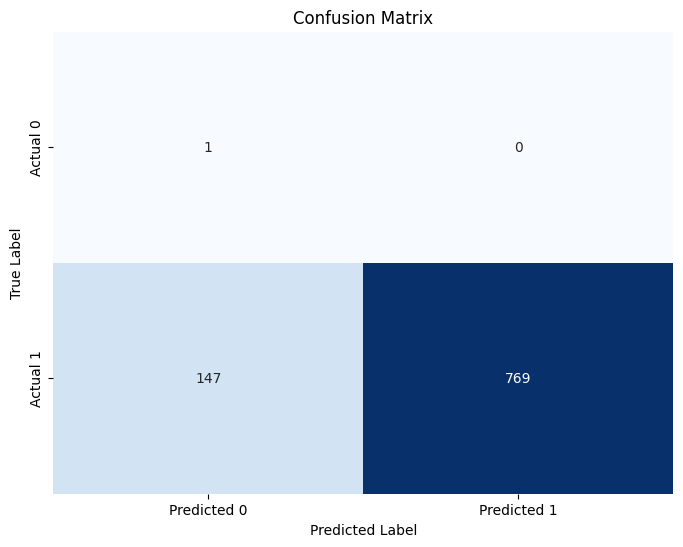

In [37]:
plot_loss(history)
plot_acc(history)
val_report(model, X_val3, y_val2)
confusion_graph(model, X_val3, y_val2)

#### Brief Interpretation - BatchNormalization and Dropout

In both cases where we had Feature selection and no feature selection, The graphs are less problematic looking - val loss isn't increasing so much val acc isn't decreasing much. Yet, they aren't really learning - they start off with high accuracy or low loss and just plateau with the validation accuracy and loss.

They all still don't predict 0s much.

Furthermore, looking at all the tests till now, the features selected by ReliefF haven't necessarily improved the results. Though the time taken is small, it was already small (e.g. 5ms per step vs 8-13 ms per step in the previous example two models).

In the tests going forward, we will only utilize the full dataset's features, especially since we will now utilize L1 regularization to help with overfitting and reducing the impact of irrelevant features.

We will revist Feature selection later in the assignment.

### Looking More Closely at the distribution of data

Here are the outputs of our validation data.

In [ ]:
y_val

,output
1207,1
3494,1
1183,0
100,1
3880,1
...,...
1717,1
3203,0
1803,1
3738,1


In [ ]:
print(y_val.value_counts())
769 / (769+148)

output
1    769
0    148
Name: count, dtype: int64


0.8386041439476554

How is the accuracy? And the loss?


In [39]:
val_report(model, X_val3, y_val2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.4299 
Validation Loss: 0.446892112493515
Validation Accuracy: 0.8396946787834167


The validation loss is relatively low but the accuracy is almost on par with the actual portion of 1s that make up the whole training data. We also saw earlier on the Confusion matrix we had no correct predictions of 0s.

In a sense, our model utilizing feature selection isn't entirely useful because its just predicting 1s and getting those "right".

In [58]:
# Make predictions on the test set
test_predictions = model2.predict(X_test_scaled)
print(test_predictions)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[0.81565166]
 [0.8730504 ]
 [0.7440743 ]
 ...
 [0.82635117]
 [0.7976588 ]
 [0.90936375]]


In [59]:
# Making prediction data frame

output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()

,id,output
0,0,0.815652
1,1,0.873050
2,2,0.744074
3,3,0.722028
4,4,0.844085


In [ ]:
#output_df.to_csv('test_pred_f.csv', index=False)

In [60]:
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]

You can check the shapes of both filters to see the distributions.

In [61]:
filter.shape

(16, 2)

Only 16 of the outputs were predicted to have outputs below 0.5 or close to 0.

It's more than some of the other examples but its far and away from the representation of 0 outputs that is actually present in the validation data. Our model needs more work to improve the representation of outputs besides one.

Let's try to improve our model now by incorporating Regularization via Lasso regression and Elastic net regression.

## Feedforward Neural Network with Regularizers - L1 and ElasticNet

From here, we are using we are using the whole set. We are also including the BatchNormalization and the Dropout layers as they seem to improve how the model learns.



In [ ]:
# Redoing train test split
X = basic2.drop(columns=['output'])

y = basic2['output']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_val2 = scaler.transform(X_val)

Scaling the test data for further predictions to submit

In [ ]:
X_test_scaled = scaler.transform(test2)

### Neural network with L1 Regularizer

**Refresher: Hypothesis** - Why are we using L1 and Elastic Net?

Regularization (L1 or Elastic Net) penalizes large coefficients, preventing the model from fitting to noise and irrelevant patterns. This means we'll limit issues like overfitting.

L1 regularization automatically selects a subset of the most relevant features by setting the least relevant ones to 0.

Elastic net combines L1 with L2 regularization, which keeps some features even if they are correlated, striking a balance between feature selection and stability.

Both of these models are useful for working with high dimensional datasets and can potentially help improve our neural network models going forth.

Using from now on X_train2, X_val2, y_train, y_val

Maintaining a kernel_regularizer with a value of 1e-4 for both L1 and L2 regularizers (in the case of Elastic Net).



In [ ]:
model = Sequential()


model.add(Dense(256, input_shape=(669,),
                activation='relu',
                kernel_regularizer=l1(1e-4)))  # L1 regularizer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(128, activation='relu',
                kernel_regularizer=l1(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu',
                kernel_regularizer=l1(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1(1e-4)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,529 (838.00 KB)

 Trainable params: 213,633 (834.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(X_train2, y_train, epochs=50, batch_size=32, validation_data=(X_val2, y_val), callbacks=[es])


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5479 - loss: 1.7229 - val_accuracy: 0.8353 - val_loss: 1.3287
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7649 - loss: 1.3683 - val_accuracy: 0.8364 - val_loss: 1.2442
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8297 - loss: 1.2593 - val_accuracy: 0.8451 - val_loss: 1.2005
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8332 - loss: 1.2127 - val_accuracy: 0.8451 - val_loss: 1.1614
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8338 - loss: 1.1985 - val_accuracy: 0.8451 - val_loss: 1.1380
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8499 - loss: 1.1292 - val_accuracy: 0.8386 - val_loss: 1.1011
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8424 - loss: 1.1117 - val_accuracy: 0.8386 - val_loss: 1.0730
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8452 - loss: 1.0629 - val_accuracy:

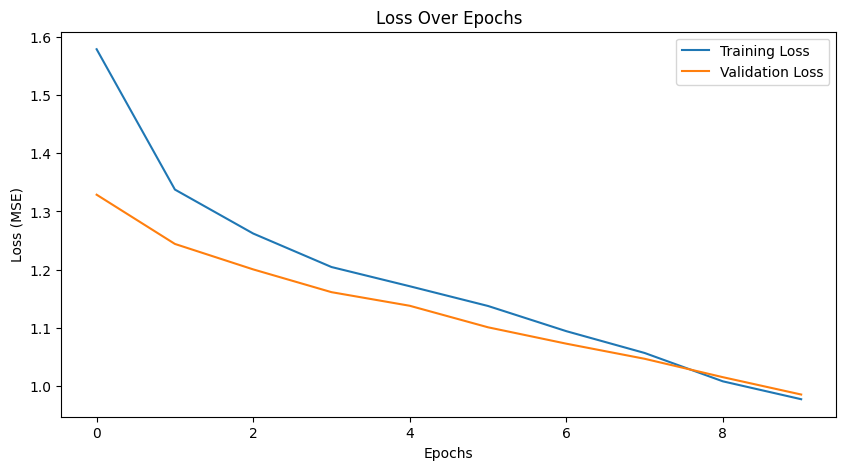

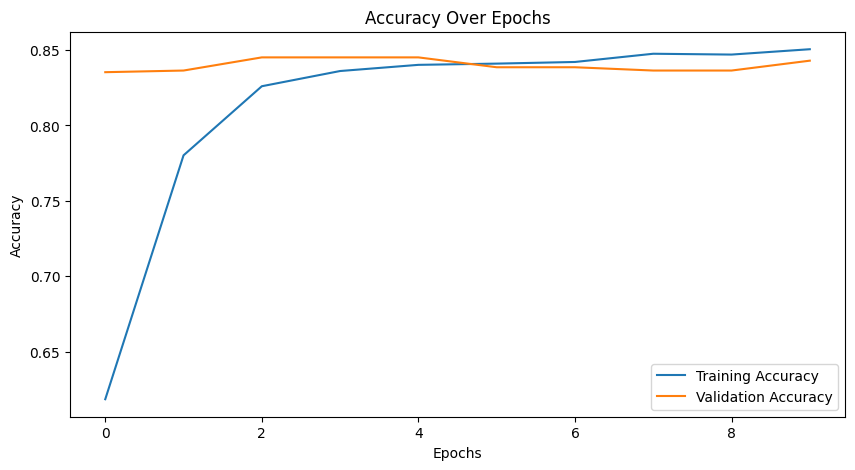

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 1.3145
Validation Loss: 1.328703761100769
Validation Accuracy: 0.8353326320648193
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.44      0.07      0.13       148
           1       0.85      0.98      0.91       769

    accuracy                           0.84       917
   macro avg       0.64      0.53      0.52       917
weighted avg       0.78      0.84      0.78       917



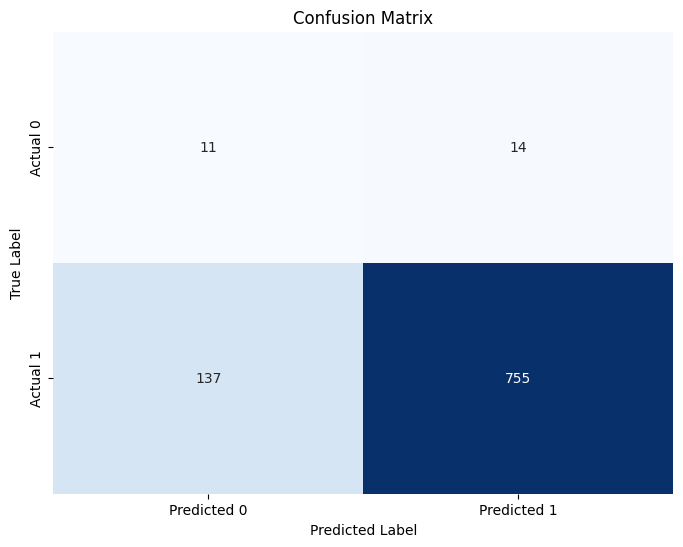

In [ ]:
plot_loss(history)
plot_acc(history)

val_report(model, X_val2, y_val)
confusion_graph(model, X_val2, y_val)

In [ ]:
# Make predictions on the test set
test_predictions = model.predict(X_test_scaled)
print(test_predictions)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.84754026]
 [0.7407907 ]
 [0.5925266 ]
 ...
 [0.58922714]
 [0.709443  ]
 [0.65115315]]


In [ ]:
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 0
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()

,id,output
0,0,0.847540
1,1,0.740791
2,2,0.592527
3,3,0.677544
4,4,0.874362


### Brief Interpretation: L1 Plots

Looking at the data, in terms of loss, the model has improved. The model is getting better at minimizing loss with the training data and validation data.

However, the accuracy doesn't grow much and it doesn't decrease much either. There isn't much learning going on when it comes to how the accuracy changes beyond the initial state. This may be in reference to the imbalance in the classes - the model may be biased toward predicting the majority class (1) from the start and thus can't learn much.

Regardless, there is some improvement in the model compared to how the loss and accuracy were presented without the L1 regularizer. Furthermore, our predictions of 0s have increased, indicating an increased representation in the data.

In [ ]:
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

(26, 2)


,count
output,
0.847540,1
0.666022,1
0.753405,1
0.696024,1
0.579913,1
...,...
0.960353,1
0.667633,1
0.825001,1


In [ ]:
#output_df.to_csv('test_pred_f.csv', index=False)

### Elastic Net attempt

We will now construct a neural Network using an elastic net regularizer.

In [ ]:
model1 = Sequential()


# Input Layer with ElasticNet (L1 + L2) regularization
model1.add(Dense(256, input_shape=(X_train2.shape[1],),
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.3))

model1.add(Dense(128, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Dense(64, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))


model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model1.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,529 (838.00 KB)

 Trainable params: 213,633 (834.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model1.fit(X_train2, y_train, epochs=50, batch_size=32, validation_data=(X_val2, y_val), callbacks=[es])


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5936 - loss: 1.7562 - val_accuracy: 0.8419 - val_loss: 1.3502
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7672 - loss: 1.4046 - val_accuracy: 0.8484 - val_loss: 1.2821
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8209 - loss: 1.3000 - val_accuracy: 0.8419 - val_loss: 1.2529
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8310 - loss: 1.2652 - val_accuracy: 0.8441 - val_loss: 1.2077
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8392 - loss: 1.2095 - val_accuracy: 0.8473 - val_loss: 1.1771
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8231 - loss: 1.1973 - val_accuracy: 0.8430 - val_loss: 1.1495
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8547 - loss: 1.1113 - val_accuracy: 0.8408 - val_loss: 1.1096
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8475 - loss: 1.0758 - val_accuracy

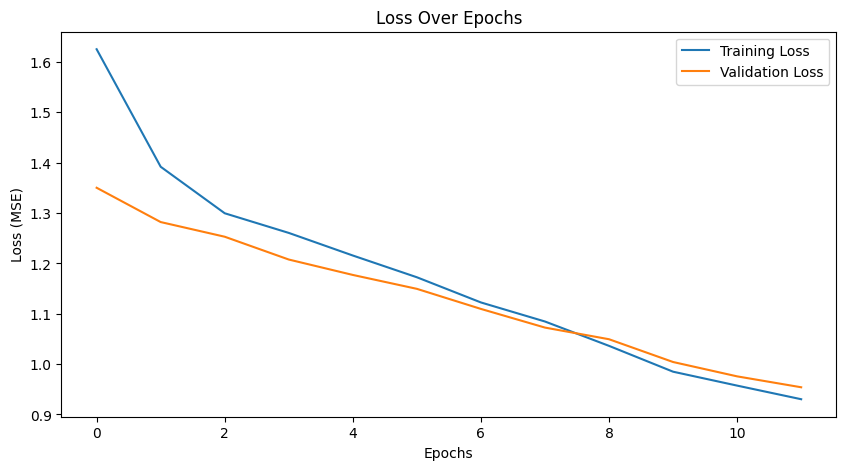

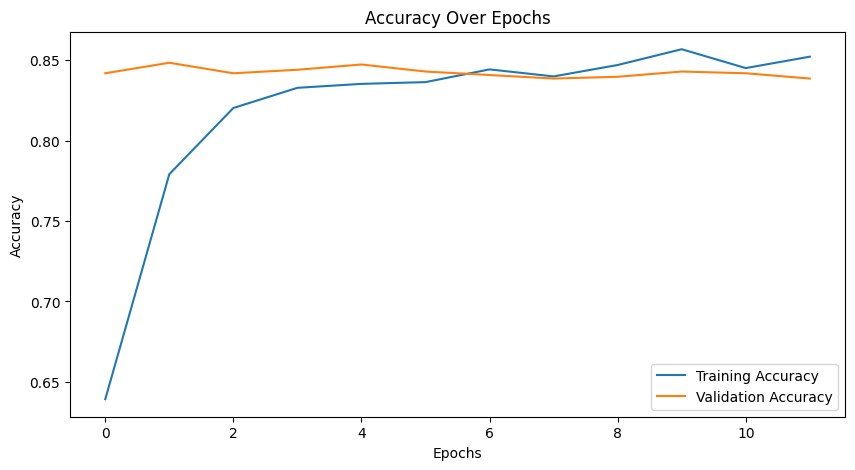

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 1.2527
Validation Loss: 1.2820665836334229
Validation Accuracy: 0.8484187722206116
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.85      0.07      0.14       148
           1       0.85      1.00      0.92       769

    accuracy                           0.85       917
   macro avg       0.85      0.54      0.53       917
weighted avg       0.85      0.85      0.79       917



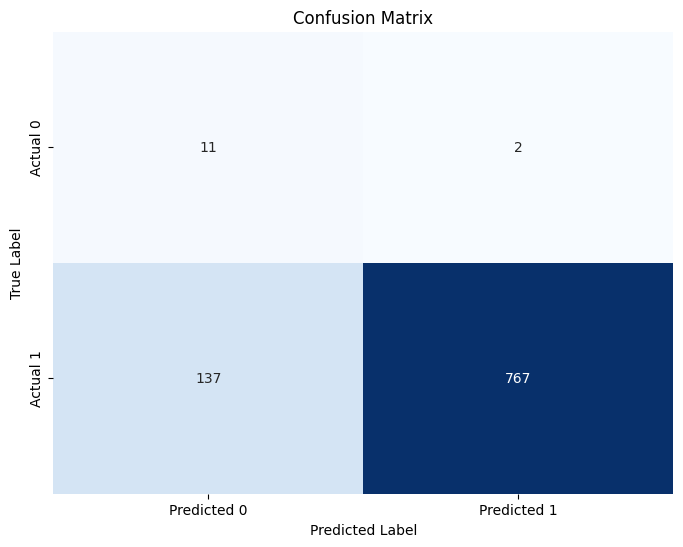

In [ ]:
plot_loss(history)
plot_acc(history)

val_report(model1, X_val2, y_val)
confusion_graph(model1, X_val2, y_val)

### Brief Interpretation: Elastic Net Plots

Looking at the data, in terms of loss, the model has improved and the loss reaches what appears to be convergence at about 7 or 8 epochs in. The model is getting better at minimizing loss with the training data and validation data.

However, the accuracy doesn't grow much. There isn't much learning going on when it comes to how the accuracy changes beyond the initial state. This may be in reference to the imbalance in the classes - the model may be biased toward predicting the majority class (1) from the start and thus can't learn much.

Regardless, there is some improvement in the model compared to how it was without the regularizers.

We can conclude that the models made some improvement with the presence of the regularizers.

In [ ]:
# Make predictions on the test set

test_predictions = model1.predict(X_test_scaled)
print(test_predictions)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.9087343 ]
 [0.91757005]
 [0.7002486 ]
 ...
 [0.7910383 ]
 [0.80449545]
 [0.8649292 ]]


In [ ]:

output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),
     'output': test_predictions.flatten()
 })

output_df.head()

,id,output
0,0,0.908734
1,1,0.917570
2,2,0.700249
3,3,0.522443
4,4,0.901228


In [ ]:

filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

(10, 2)


,count
output,
0.908734,1
0.834846,1
0.891233,1
0.763579,1
0.812562,1
...,...
0.793705,1
0.895635,1
0.939369,1


In [ ]:
#output_df.to_csv('test_pred_f.csv', index=False)

## Decision Tree Classifier - Attempt

We haven't seen much actual improvement in our actual validation accuracy when using or modulating the Neural Networks in various ways. Though errors / loss has decreased, there hasn't been much change in validation accuracy and the models' learning hasn't shown much improvement or growth.

As a diversion, we experimented with a DecisionTreeClassifier to see how well it could predict the outputs. We selected this model of Decision tree due to its capability in providing binary outputs based on input features. We hypothesized that a decision tree with a Max Depth of 3 wouldn't perform as well as our neural network models.

Here we instantiate and fit the tree. We also made our predictions and used the model to make predictions based on the validation data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree= DecisionTreeClassifier(max_depth=3)

tree.fit(X_train2, y_train)

predictions = tree.predict(X_val2)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predictions, y_val))

0.8418756815703381


Contrary to our hypothesis, it managed to do about as well as our neural network models did.

Despite these being binary outputs, we decided to use them for an attempt to see if they were successful.

In [ ]:
output_df = pd.DataFrame({
     'id': range(0, len(predictions)),  # ID column counting from 0
     'output': predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()

,id,output
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [ ]:
#output_df.to_csv("test_pred_tree.csv",index=False)

In [ ]:

filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

(101, 2)


,count
output,
1,816




---

One thing we realized is that the model's high validation accuracy could largely be traced back to how the model was just predicting 1 many, many times.

In [ ]:
basic
print(basic['output'].value_counts())
print(3873/(3873+711))


output
1    3873
0     711
Name: count, dtype: int64
0.8448952879581152


Approximately 84.4% of the training data is comprised of the output 1. This is pretty skewed and has / will affect our ability to predict outputs from a model.

Furthermore, this is about the accuracy that we have when we check our training data against the validation data - which means that so long as it predicts 1 constantly, it could theoretically get about 84.4% accuracy within the training data and the model wouldn't be very useful in that case.

What can we do about this?

For one, we consistently see low representation / few predictions of 0 or less than 0.5 from our predictions based on our validation data and in our test predictions, despite 0s making up about 20% of the validation data.

We might try to improve the representation of 0s in our data to help get us to predict them more. While this may affect our ability to predict the other output, 1, it may also mean that our model will better generalize to new data or be able to properly predict an output as opposed to spamming 1s.

One way to do this may be by utilizing resampling (e.g. SMOTE) to help improve the representation of the data - i.e. outputs of 0.



## Class Imbalance - SMOTE and Resampling

In [ ]:
!pip install imbalanced-learn


### Basic Feedforward Neural Network with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)

# Define and train the neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[es])

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6660 - loss: 0.6068 - val_accuracy: 0.7121 - val_loss: 0.5548
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8440 - loss: 0.3568 - val_accuracy: 0.7176 - val_loss: 0.5776
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8864 - loss: 0.2835 - val_accuracy: 0.7666 - val_loss: 0.5783
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9111 - loss: 0.2231 - val_accuracy: 0.7503 - val_loss: 0.6387
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9309 - loss: 0.1827 - val_accuracy: 0.7655 - val_loss: 0.6702
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9337 - loss: 0.1655 - val_accuracy: 0.7459 - val_loss: 0.7589
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9620 - loss: 0.1229 - val_accuracy: 0.7623 - val_loss: 0.8212
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9519 - loss: 0.1276 - val_accuracy: 0.

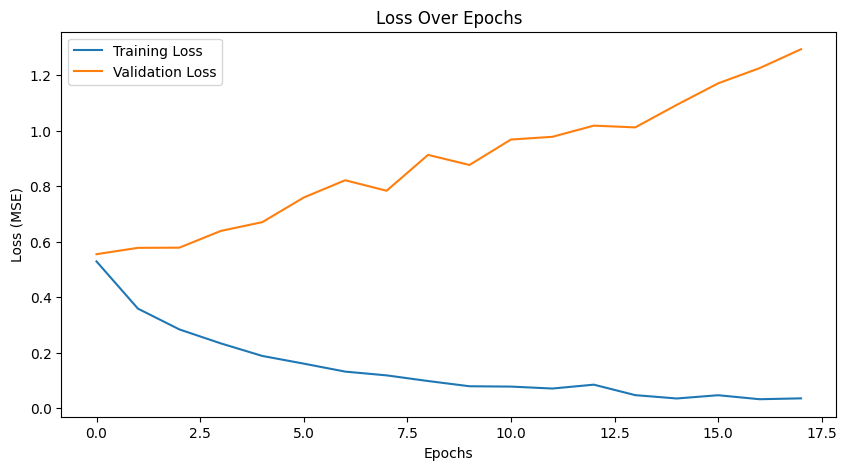

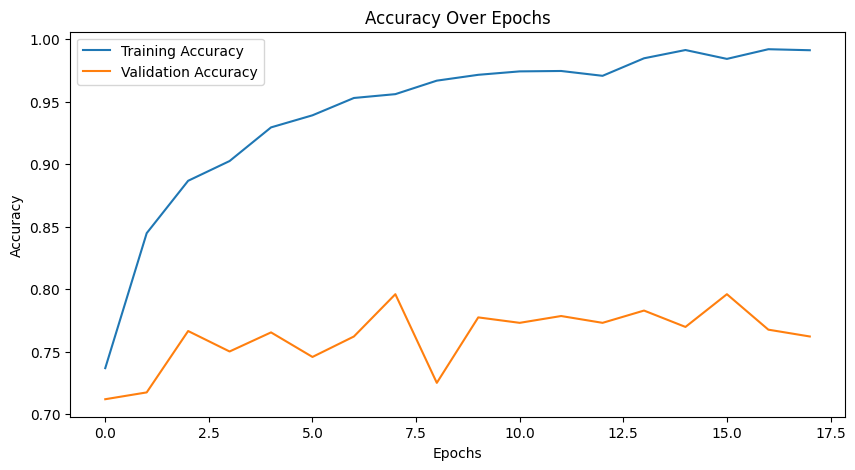

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7933 - loss: 0.7695 
Validation Loss: 0.7833767533302307
Validation Accuracy: 0.7960741519927979
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.33      0.25      0.28       148
           1       0.86      0.90      0.88       769

    accuracy                           0.80       917
   macro avg       0.59      0.58      0.58       917
weighted avg       0.78      0.80      0.78       917



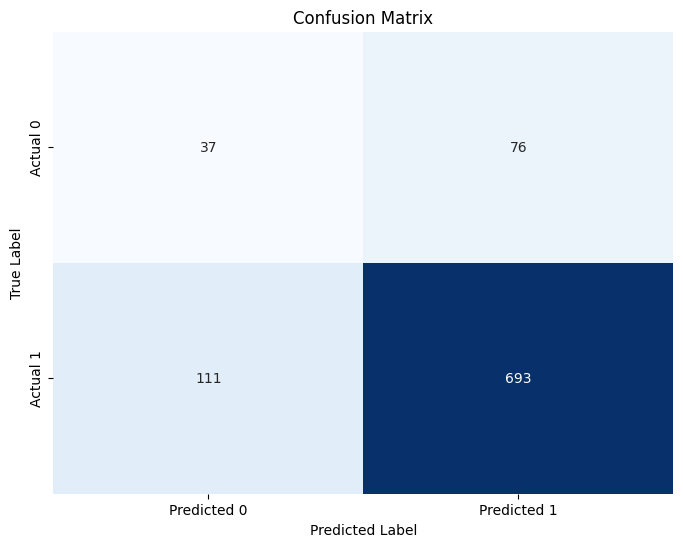

In [ ]:
plot_loss(history)
plot_acc(history)
val_report(model, X_val_scaled, y_val)
confusion_graph(model, X_val_scaled, y_val)

### Feedforward Neural Network with BatchNormalization and Dropout and SMOTE

In [ ]:
model = Sequential()

model.add(Dense(256, input_shape=(X_train_resampled.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks = [es])

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)                    │ (None, 256)                 │         171,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_75 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_76 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_69               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_77 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,529 (838.00 KB)

 Trainable params: 213,633 (834.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5824 - loss: 0.7238 - val_accuracy: 0.7688 - val_loss: 0.4978
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7526 - loss: 0.5121 - val_accuracy: 0.7470 - val_loss: 0.5342
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7936 - loss: 0.4350 - val_accuracy: 0.7328 - val_loss: 0.5778
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8206 - loss: 0.4007 - val_accuracy: 0.7415 - val_loss: 0.5625
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8369 - loss: 0.3692 - val_accuracy: 0.7535 - val_loss: 0.5582
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8465 - loss: 0.3563 - val_accuracy: 0.7677 - val_loss: 0.5646
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8687 - loss: 0.3193 - val_accuracy: 0.7568 - val_loss: 0.5822
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8735 - loss: 0.3050 - val_accuracy

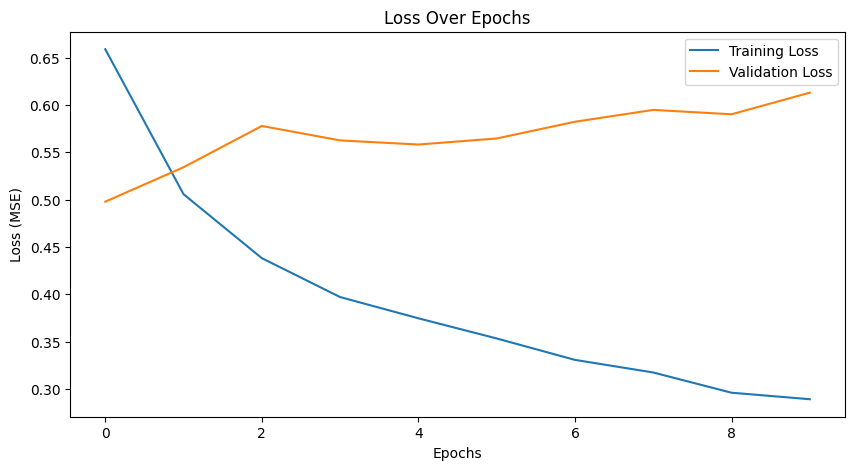

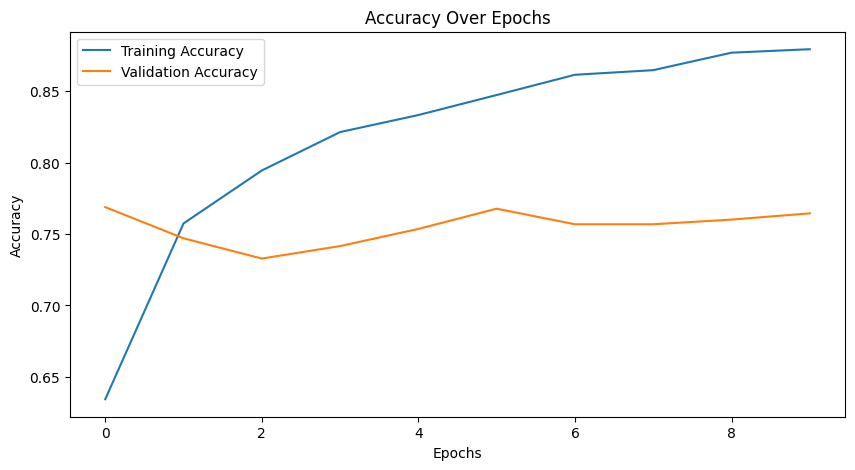

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7629 - loss: 0.4917
Validation Loss: 0.49782466888427734
Validation Accuracy: 0.7688113451004028
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.31      0.36      0.33       148
           1       0.87      0.85      0.86       769

    accuracy                           0.77       917
   macro avg       0.59      0.60      0.60       917
weighted avg       0.78      0.77      0.78       917



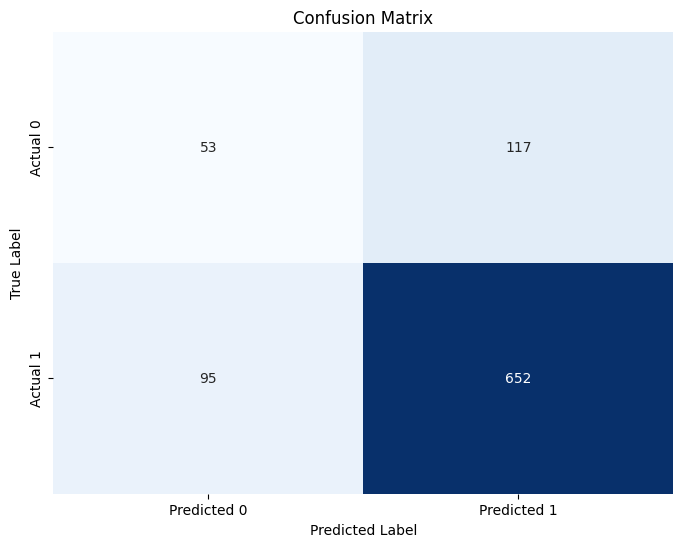

In [ ]:
plot_loss(history)
plot_acc(history)
val_report(model, X_val_scaled, y_val)
confusion_graph(model, X_val_scaled, y_val)

In [ ]:

test_predictions = model.predict(X_test_scaled)
print(test_predictions)

output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

print(output_df.head())

filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.5976574 ]
 [0.77906775]
 [0.3416509 ]
 ...
 [0.6285212 ]
 [0.7351303 ]
 [0.89763576]]
   id    output
0   0  0.597657
1   1  0.779068
2   2  0.341651
3   3  0.798429
4   4  0.667796
(467, 2)


In [ ]:
#output_df.to_csv('test_pred_smote.csv', index=False)

### Brief Interpretation: SMOTE and Plots


As expected, our quantity of 0s did go up within our predictions while the quantity of 1s decreased. However, this change was too drastic as our validation accuracy decreased too much - from about 83% to 77-79%.

Furthermore, there was great overfitting in our graphs and our loss started increasing a lot during the training with an overall loss in the validation accuracy.



---



Looking at our predictions, we see that, if we use a 0.5 cut off for our binary classifier, there are 467 predictions that would effectively be a 0 which is about 27% of the data in the Test set.

We limited the tests with SMOTE as the validation accuracy wasn't high enough to justify to ourselves that we should continue using regularizers to improve it - more than likely, it wouldn't go up past 80% due to them.

We haven't necessarily improved in predicting the data. What we can do is begin re-evaluating the dataset and how we've fed in the data.

Let's look back and pre-process the data once again.





# Section where we do a pipeline preprocessing

### Plan: Preprocessing Part 2

We revisited the way we pre-processed the data and redid it after further investigation. We chose to change how we encode, and proceeded to apply different scalers to the columns depending on the data type.



## Revisiting the Data for further Preprocessing

Looking closely at the data, there are a number of columns that only have 0s and 1s - hinting at one-hot encoding. Thus we treated the data like that and elected not to subject them to scaling.

In [ ]:
intcol = basic.select_dtypes(include=['int']).columns

print(basic[intcol].head(), "\n")

# Some int columns have plenty of different values. Others don't

binary_columns = basic.columns[(basic.isin([0, 1]).all(axis=0) & (basic.nunique() == 2))]



   x1  x2  x3  x4  x14  x20  x21  x22  x23  x39  ...  z125  z126  z127  z128  \
0   0   0   0   1  401   67   78  193  208    1  ...     1     1     1     1   
1   0   0   0   1  401   45   65  194  207    1  ...     1     1     1     1   
2   0   0   0   0  401   52   48  204  197    1  ...     1     1     1     1   
3   0   0   0   1  401   36   35  185  216    1  ...     1     1     1     1   
4   0   0   0   0  401   94  106  176  225    1  ...     1     1     1     1   

   z129  z130  z131  z132  phase  output  
0     1     1     1     1      3       1  
1     1     1     1     1      4       1  
2     1     1     1     1      3       1  
3     1     1     1     1      2       0  
4     1     1     1     1      2       1  

[5 rows x 194 columns] 



In [ ]:
# Isolating the "binary" or one-hot encoded columns

basic[binary_columns]

,x2,x3,x4,x40,x41,x42,x43,x44,x45,x46,...,z45,z46,z47,z114,z115,z116,z117,z118,z119,output
0,0,0,1,1,1,1,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
2,0,0,0,1,1,1,1,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
4,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,0,0,1,1,1,1,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
4580,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0
4581,0,0,1,1,1,1,1,1,1,0,...,0,0,0,1,1,1,1,1,1,1
4582,0,0,1,1,1,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0


Phase appears to be composed of numbers like 1,2,3,4. We interpret that as ordinal data and changed the way we scaled it.

We utilized a MinMaxScaler instead as it could preserve the relative order of the values (e.g. 1 < 2 < 3 < 4) without distorting their magnitude.

In [ ]:
basic['phase']

,phase
0,3
1,4
2,3
3,2
4,2
...,...
4579,3
4580,2
4581,4
4582,3


Finally, because the columns 'state' and 'subject' seemed to be made of strings, we elected to utilize One-Hot Encoding this time.

We deemed some of the issue with utilizing this variable as a flaw of our improper utilization of Label Encoding. We also chose to utilize one-hot encoding because it could naturally handle unseen categories (i.e. the contents of the "subject" column that were different in the test data from the training data).



---

Our Hypothesis is that, from here on, our models will improve as we have utilized more specific and proper encodings along with scaling for our data.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l1_l2


In [ ]:
basic = pd.read_csv('/content/unzipped/train_data.csv')
test = pd.read_csv('/content/unzipped/test_data.csv')

categorical_cols = basic.select_dtypes(include=['object', 'category']).columns
numerical_cols = basic.select_dtypes(include=['int64', 'float64']).columns

binary_columns = basic.columns[(basic.isin([0, 1]).all(axis=0) & (basic.nunique() == 2))]

def plot_acc(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def plot_loss(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.show()

We are executing making lists to input into the Pipeline so we can set the different columns to encoding, scaling, or passing through.

In [ ]:
s = categorical_cols.to_list()
#s.append('phase')

In [ ]:
phase = ['phase']

In [ ]:
bin = binary_columns.to_list()
bin.remove('output')

In [ ]:
num=numerical_cols.to_list()
num = [col for col in num if col not in bin]
num = [col for col in num if col not in s]

num.remove('output')
len(num)

617

Here we execute the process of remaking our training data. We utilize a Pipeline and a ColumnTransformer to process our data.

In [ ]:
X = basic.drop('output', axis=1)  # Assume 'numerical_feature' is the target for this example
y = basic['output']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), s),          # One-hot encode categorical features
        ('phase', MinMaxScaler(), phase),
        ('bin', 'passthrough', bin)                  # Leave binary features as they are
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)




In [ ]:
# Fit the pipeline on the training data and transform the training set
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the validation set using the same fitted pipeline
X_val_transformed = pipeline.transform(X_val)


In [ ]:
X_train_transformed

array([[ 0.        ,  1.32399916, -1.17497645, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        , -0.75402388, -0.91636459, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        , -0.23614277,  1.02782657, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 0.        , -0.76012708, -0.69475057, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        , -0.56834965, -1.00400496, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.96125593,  1.93786388, ...,  1.        ,
         1.        ,  1.        ]])

## Simple Feedforward Neural Network with Pipeline

Here we construct a simple feedforward neural network with a single dropout layer to test out the newly preprocessed data.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_transformed.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Testing it on 20 epochs
history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=20, batch_size=32, verbose=1, callbacks=[es])


val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 128)                 │          87,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,001 (375.00 KB)

 Trainable params: 96,001 (375.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8343 - loss: 0.4563 - val_accuracy: 0.8397 - val_loss: 0.4172
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8416 - loss: 0.3915 - val_accuracy: 0.8397 - val_loss: 0.3928
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8461 - loss: 0.3697 - val_accuracy: 0.8353 - val_loss: 0.3858
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8699 - loss: 0.3269 - val_accuracy: 0.8484 - val_loss: 0.3809
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8671 - loss: 0.3280 - val_accuracy: 0.8332 - val_loss: 0.3843
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8672 - loss: 0.3104 - val_accuracy: 0.8528 - val_loss: 0.3790
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8794 - loss: 0.2868 - val_accuracy: 0.8353 - val_loss: 0.3927
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8799 - loss: 0.2741 - val_accuracy: 0.

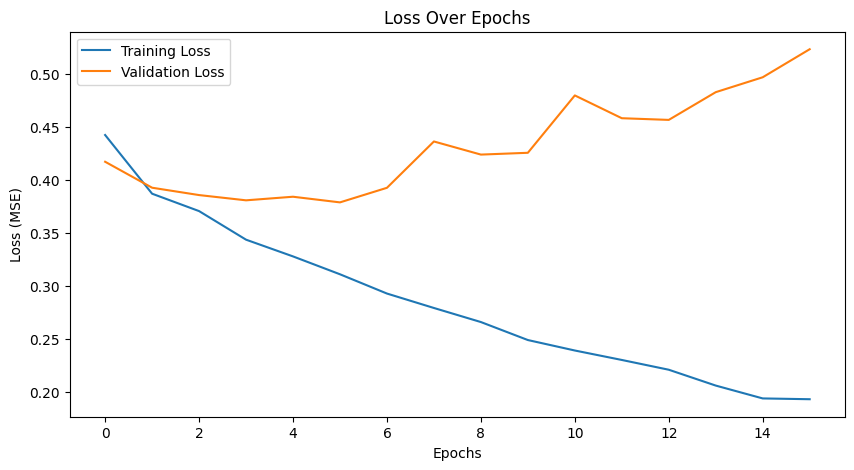

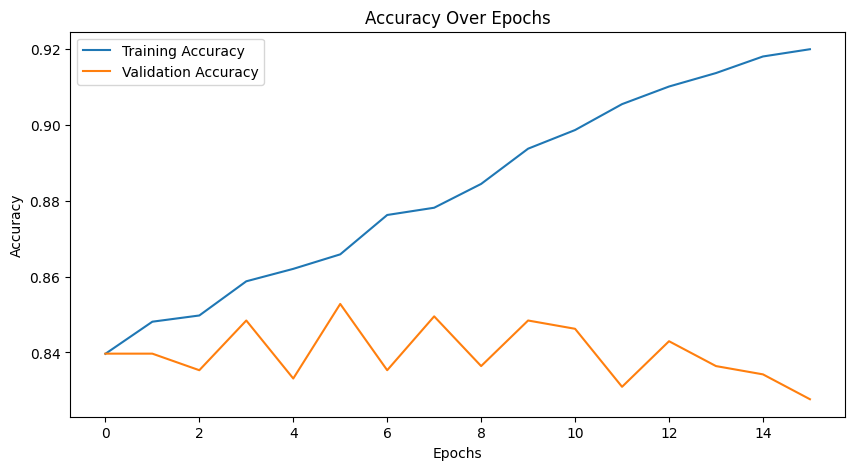

In [ ]:
plot_loss(history)
plot_acc(history)

### Brief Interpretation: Plots

The validation loss initially decreases but then starts to increase after a few epochs (around epoch 5). This suggests that the model is starting to overfit — it performs well on the training data but struggles to generalize to unseen data. In addition, there is a noticeable gap between the training accuracy and validation accuracy over time, which reinforces that the model is overfitting.

Yet, this is one of the best validation accuracies we've had to date.




---

Looking at the classification report, the accuracy for predicting the 1s and 0s has improved. It seems clear that utilizing this pipeline has caused noticeable improvement in our results.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       0.62      0.22      0.32       148
           1       0.87      0.97      0.92       769

    accuracy                           0.85       917
   macro avg       0.74      0.60      0.62       917
weighted avg       0.83      0.85      0.82       917



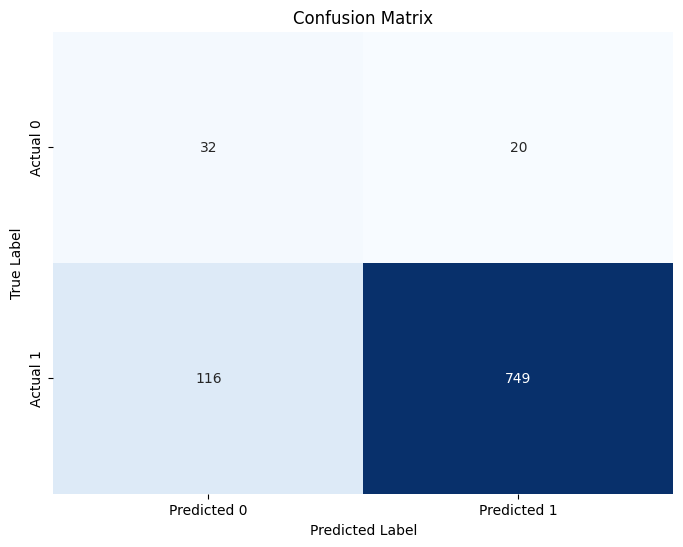

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


predictions = model.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.90157604]
 [0.8550165 ]
 [0.8710964 ]
 ...
 [0.9318858 ]
 [0.84549874]
 [0.80142814]]
(57, 2)


,count
output,
0.901576,1
0.950453,1
0.716372,1
0.921763,1
0.839296,1
...,...
0.948613,1
0.659890,1
0.839384,1


In [ ]:
#output_df.to_csv('test_predictions_pipeline.csv', index=False)

## Feedforward Network utilizing Pipeline, BatchNormalization, and Dropout

Like we did before, we'll be utilizing 3 layers with dropout of 0.3 and BatchNormalization to improve our model.

Here we re-execute the preprocessor for safety.

We're going to explore using these the BatchNormalization and Dropout layers for our neural network because we believe it will potentially improve the loss curve compared to the initial feedforward network example. It may even improve the validation accuracy.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), s),          # One-hot encode categorical features
        ('phase', MinMaxScaler(), phase),
        ('bin', 'passthrough', bin)                  # Leave binary features as they are
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data and transform the training set
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the validation set using the same fitted pipeline
X_val_transformed = pipeline.transform(X_val)



X_test_transformed = pipeline.transform(test)

Here we make our neural network model with the additional BatchNormalization and Dropout layers.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(256, input_shape=(X_train_transformed.shape[1],)))
model.add(BatchNormalization())  # Batch normalization
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Dropout for regularization

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_146 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_73               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_81 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_82 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_83 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model for max 40 epochs
history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8419 - loss: 0.4237 - val_accuracy: 0.8375 - val_loss: 0.4101
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8452 - loss: 0.4043 - val_accuracy: 0.8386 - val_loss: 0.4088
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8403 - loss: 0.3920 - val_accuracy: 0.8539 - val_loss: 0.3844
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8632 - loss: 0.3552 - val_accuracy: 0.8397 - val_loss: 0.4075
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8550 - loss: 0.3440 - val_accuracy: 0.8386 - val_loss: 0.3857
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8492 - loss: 0.3528 - val_accuracy: 0.8386 - val_loss: 0.3931
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8609 - loss: 0.3234 - val_accuracy: 0.8332 - val_loss: 0.3935
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8536 - loss: 0.3317 - val_accu

Here we evaluate the model on validation data, using the best model.

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.3585
Validation Loss: 0.3844, Validation Accuracy: 0.8539


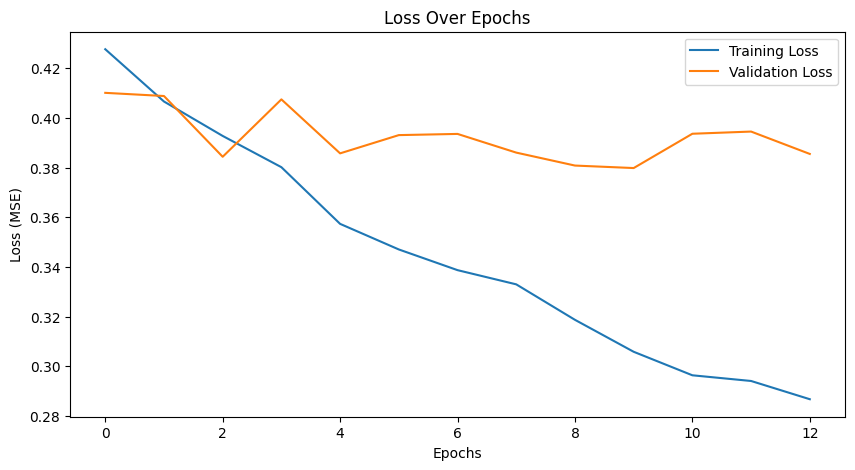

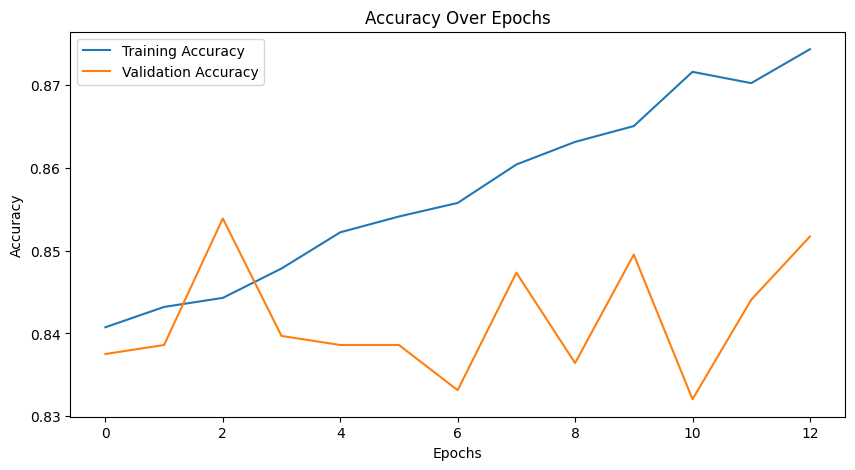

In [ ]:
plot_loss(history)
plot_acc(history)

### Brief Interpretation: Plots

Our loss curve isn't technically as bad as before. There is still overfitting and sporadic changes in both the accuracy and loss but the loss isn't increasing much more from where it started. Our validation accuracy was sporadically higher this time with an early spike 2 epochs in. The learning process may need improvements. We will continue forward with regularizers.



---

Here we execute getting the predictions once again and our Confusion Matrix.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.75      0.14      0.24       148
           1       0.86      0.99      0.92       769

    accuracy                           0.85       917
   macro avg       0.80      0.57      0.58       917
weighted avg       0.84      0.85      0.81       917



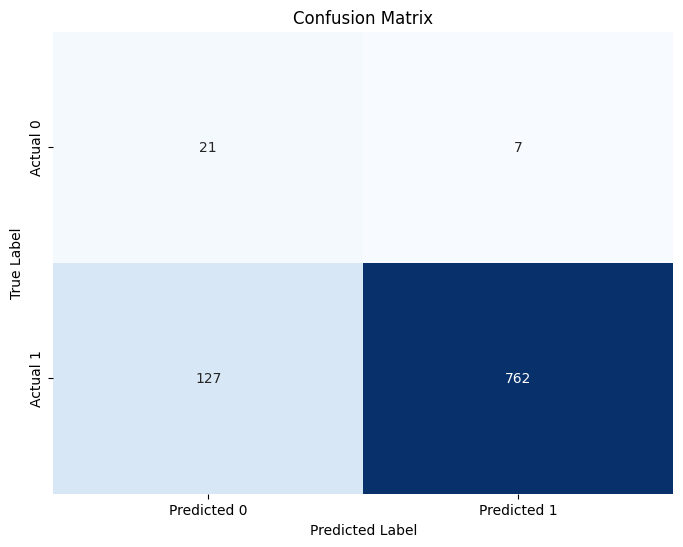

In [ ]:
predictions = model.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),
     'output': test_predictions.flatten()
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.7635995 ]
 [0.79534835]
 [0.74591404]
 ...
 [0.83560973]
 [0.8668292 ]
 [0.8904091 ]]
(29, 2)


,count
output,
0.763600,1
0.864839,1
0.789491,1
0.802482,1
0.907448,1
...,...
0.918382,1
0.991718,1
0.872559,1


In [ ]:
#output_df.to_csv('test_predictions_pipeline_improving.csv', index=False)

We got score of .64688. The method has improved marginally - from .64288 to now .64688. Moving on to using regularizers.

# Pipeline with regularizers (L1, Elastic Net)

### Neural Network using the Pipeline and L1 regularization

We are now testing out a model that utilizes Dropout, BatchNormalization, and L1 regularization.

In [ ]:
model = Sequential()


# Input Layer with(L1) regularization
model.add(Dense(256, input_shape=(X_train_transformed.shape[1],),
                activation='relu',
                kernel_regularizer=l1(1e-4)))
model.add(BatchNormalization())  # Batch normalization
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Dropout for regularization

model.add(Dense(128, activation='relu',
                kernel_regularizer=l1(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer with L1 regularization
model.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1(1e-4)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_84 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,921 (820.00 KB)

 Trainable params: 209,153 (817.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5958 - loss: 1.6177 - val_accuracy: 0.7710 - val_loss: 1.2329
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8021 - loss: 1.2291 - val_accuracy: 0.8299 - val_loss: 1.1444
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8341 - loss: 1.1326 - val_accuracy: 0.8419 - val_loss: 1.0897
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8372 - loss: 1.0823 - val_accuracy: 0.8462 - val_loss: 1.0411
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8423 - loss: 1.0593 - val_accuracy: 0.8441 - val_loss: 1.0200
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8521 - loss: 0.9839 - val_accuracy: 0.8419 - val_loss: 0.9772
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8619 - loss: 0.9456 - val_accuracy: 0.8484 - val_loss: 0.9548
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8657 - loss: 0.8804 - val_acc

In [ ]:
# Step 7: Evaluate the Model on Validation Data
val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8609 - loss: 0.8370
Validation Loss: 0.8647, Validation Accuracy: 0.8528


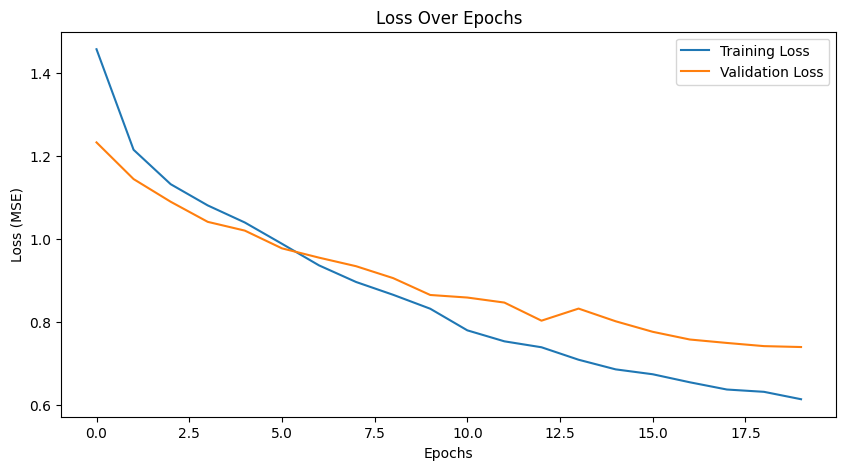

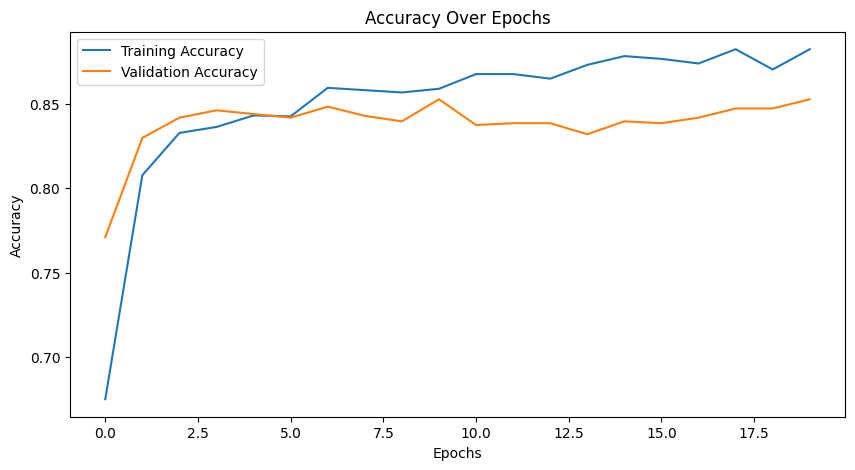

In [ ]:
plot_loss(history)
plot_acc(history)

#### Brief Interpretation: Plots

The validation loss and accuracy curves look much better. The loss is actually decreasing almost in time with the training loss and, to an extent, the validation accuracy curve is increasing with the training accuracy curve. The overfitting appears to have decreased in magnitude somewhat. Finally, the validation accuracy appears to have reached 0.8528.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.66      0.18      0.29       148
           1       0.86      0.98      0.92       769

    accuracy                           0.85       917
   macro avg       0.76      0.58      0.60       917
weighted avg       0.83      0.85      0.82       917



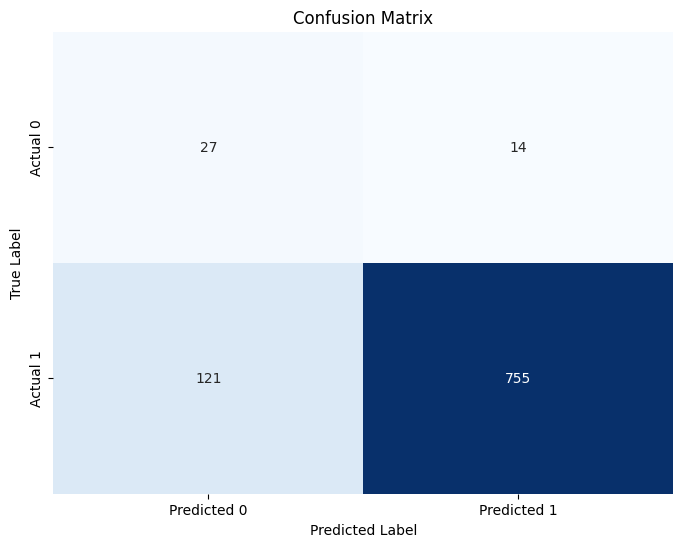

In [ ]:
predictions = model.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[[0.4874188 ]
 [0.8672966 ]
 [0.86808926]
 ...
 [0.8934434 ]
 [0.9011916 ]
 [0.9267428 ]]
(70, 2)


,count
output,
0.868768,2
0.867297,1
0.880005,1
0.942135,1
0.912006,1
...,...
0.876595,1
0.957377,1
0.991655,1


The amount of smaller values / potential 0s appears to be increasing which is a good sign. We'll submit this model as a .csv.

In [ ]:
#output_df.to_csv('test_predictions_pipeline_l1.csv', index=False)

## Neural Network utilizing the Pipeline and Elastic Net

Here we design a method to complete the act of preprocessing the data before we test it.

In [ ]:
def preprocess(num, s, phase, bin, X, y, test):

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', StandardScaler(), num),
          ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), s),
          ('phase', MinMaxScaler(), phase),
          ('bin', 'passthrough', bin)
      ]
  )

  pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor)
  ])


  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


  X_train_transformed = pipeline.fit_transform(X_train)


  X_val_transformed = pipeline.transform(X_val)



  X_test_transformed = pipeline.transform(test)

  return X_train_transformed, X_val_transformed, X_test_transformed

Here we obtain the variables for the transformed data.

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

In [ ]:

model = Sequential()


# Input Layer with ElasticNet (L1 + L2) regularization
model.add(Dense(256, input_shape=(X_train_transformed.shape[1],),
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_78               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_85 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_79               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,921 (820.00 KB)

 Trainable params: 209,153 (817.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5771 - loss: 1.6779 - val_accuracy: 0.8364 - val_loss: 1.2367
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8016 - loss: 1.2612 - val_accuracy: 0.8441 - val_loss: 1.1761
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8269 - loss: 1.1802 - val_accuracy: 0.8353 - val_loss: 1.1320
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8406 - loss: 1.1100 - val_accuracy: 0.8484 - val_loss: 1.0781
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8561 - loss: 1.0408 - val_accuracy: 0.8441 - val_loss: 1.0295
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8488 - loss: 0.9964 - val_accuracy: 0.8506 - val_loss: 0.9913
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8622 - loss: 0.9216 - val_accuracy: 0.8451 - val_loss: 0.9462
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8543 - loss: 0.9017 - val_accu

In [ ]:

val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8770 - loss: 0.7058
Validation Loss: 0.7371, Validation Accuracy: 0.8615


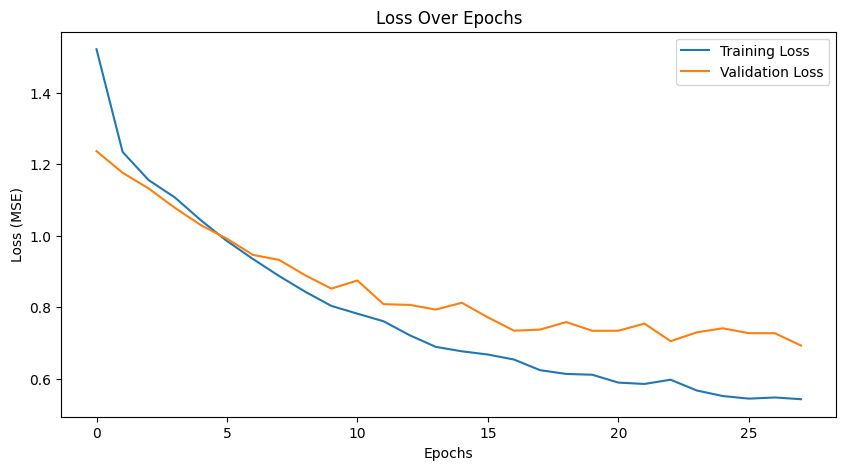

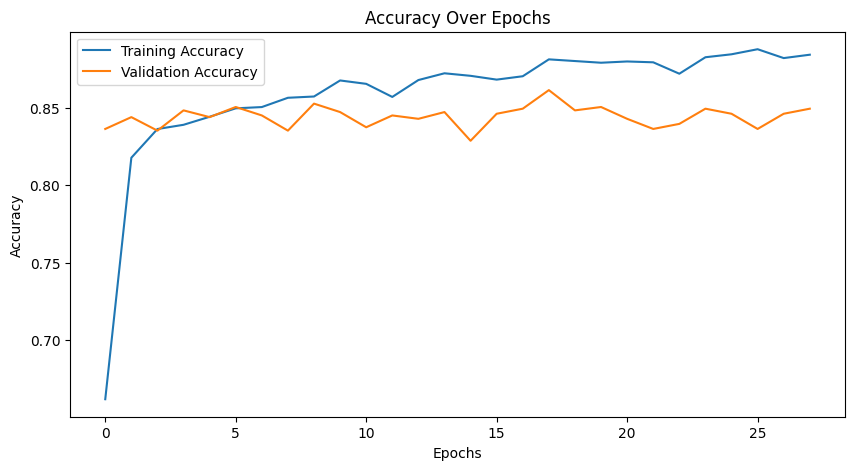

In [ ]:
plot_loss(history)
plot_acc(history)

### Brief Interpretation: Plots

The validation loss and accuracy curves look good again, though they could do with being less sporadic. The overfitting appears to have decreased in magnitude like the L1 curve had. We have also reached a new high for the validation accuracy - 0.8615 - and we managed to train for about 28 epochs. Considering where we were before, barely able to get past 15 epochs in training with the callbacks, this is a sign of learning improving.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.74      0.22      0.34       148
           1       0.87      0.99      0.92       769

    accuracy                           0.86       917
   macro avg       0.81      0.60      0.63       917
weighted avg       0.85      0.86      0.83       917



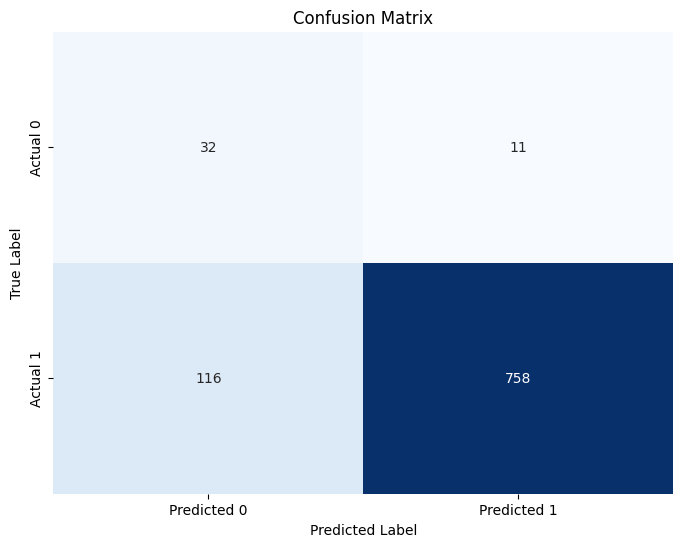

In [ ]:
predictions = model.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),
     'output': test_predictions.flatten()
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[0.823277  ]
 [0.99232626]
 [0.705576  ]
 ...
 [0.8917539 ]
 [0.995685  ]
 [0.8753797 ]]
(75, 2)


,count
output,
0.999999,2
0.790875,2
1.000000,2
0.997318,1
0.948668,1
...,...
0.993664,1
0.828092,1
0.918744,1


More 0 predictions. We will take this model and utilize it for the csv.

In [ ]:
#output_df.to_csv('test_predictions_pipeline_elasticnet.csv', index=False)

# Further Exploration

Despite the improvements in our validation accuracy due to the usage of the pipeline method for preprocessing our data, our test accuracy isn't improving enough.

We elect to try two more types of changes - a new optimizer and a new activation function.



*   **SGD**: Stochastic gradient descent.
*   **Leaky ReLu**: leaky rectified linear activation.



## SGD (no regularizer, L1, Elastic net)

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

We are going to make 3 different models that utilize SGD: one that uses no lasso regression (L1) or elastic net, one that uses L1 regularization, and one that uses Elastic net regularization.

We will compare the performance and see if SGD can do as well as 'Adam'.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)  # Configure SGD

# Model with no L1 regularization and no Elastic Net

model = Sequential()


model.add(Dense(256, input_shape=(X_train_transformed.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))

# Utilizing SGD optimizer
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()



Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_89               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_95 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_96 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_97 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Remake SGD optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model1 = Sequential()


# Input Layer with(L1) regularization
model1.add(Dense(256, input_shape=(X_train_transformed.shape[1],),
                activation='relu',
                kernel_regularizer=l1(1e-4)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.3))

model1.add(Dense(128, activation='relu',
                kernel_regularizer=l1(1e-4)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Dense(64, activation='relu',
                kernel_regularizer=l1(1e-4)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1(1e-4)))


model1.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])


model1.summary()


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_99 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Remake SGD again
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model2 = Sequential()


# ElasticNet (L1 + L2) regularization
model2.add(Dense(256, input_shape=(X_train_transformed.shape[1],),
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.3))

model2.add(Dense(128, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(64, activation='relu',
                kernel_regularizer=l1(1e-4)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))


model2.add(Dense(1, activation='sigmoid',
                kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))

# Compile the model
model2.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model2.summary()


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_179 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_100 (Activation)          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_180 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

We are adding all the models to a list, executing training them, and then adding their histories to a list where we can evaluate their validation loss and accuracy.

In [ ]:
models = [model, model1, model2]
hist = []

In [ ]:
for model in models:
  es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)
  history = model.fit(X_train_transformed, y_train,
                      validation_data=(X_val_transformed, y_val),
                      epochs=40, batch_size=32, verbose=0, callbacks=[es])

  hist.append(history)

  val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
  print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8714 - loss: 0.3626
Validation Loss: 0.3808, Validation Accuracy: 0.8495
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - loss: 1.2367
Validation Loss: 1.2691, Validation Accuracy: 0.8495
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8648 - loss: 1.1696
Validation Loss: 1.1922, Validation Accuracy: 0.8441


Best val acc was the L1 model with SGD and the model without regularizers. However, the loss was lower for the model without regularizers. Let's look closer at their graphs.

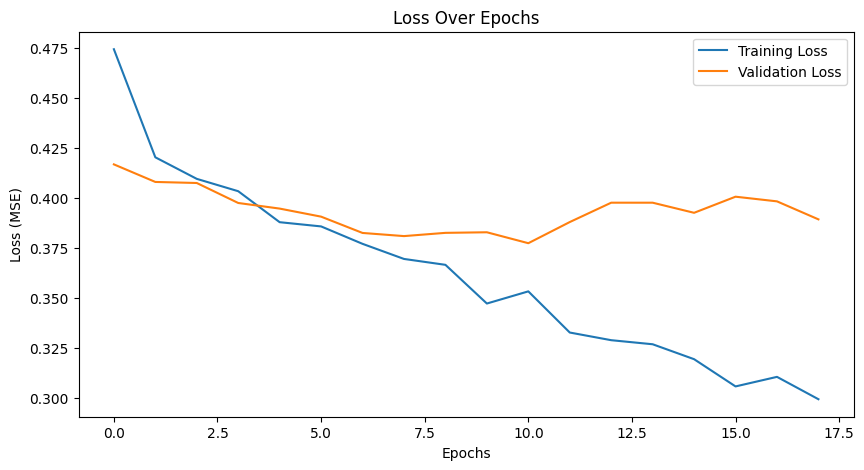

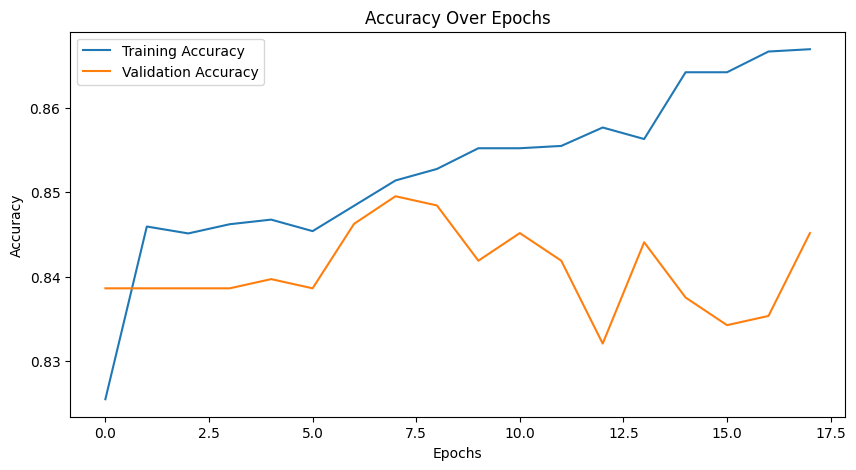

In [ ]:
plot_loss(hist[0])
plot_acc(hist[0])

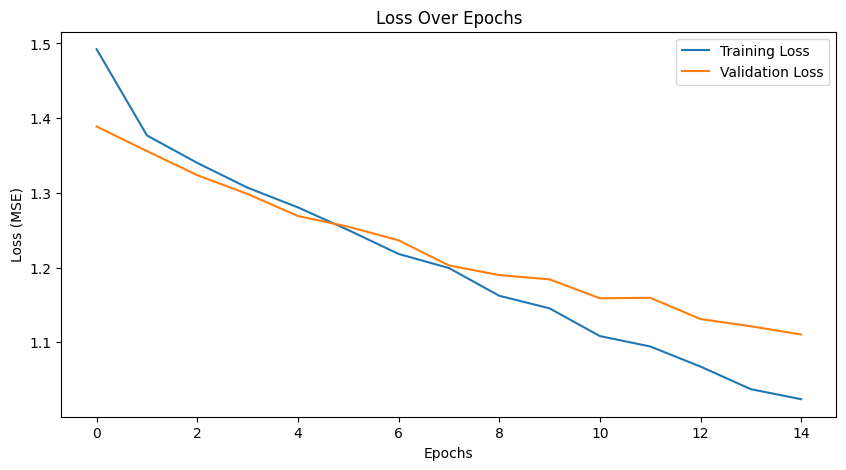

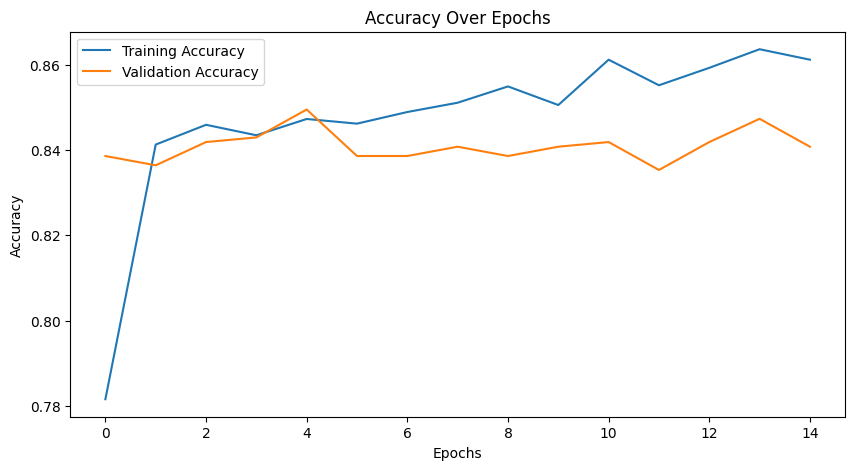

In [ ]:
plot_loss(hist[1])
plot_acc(hist[1])

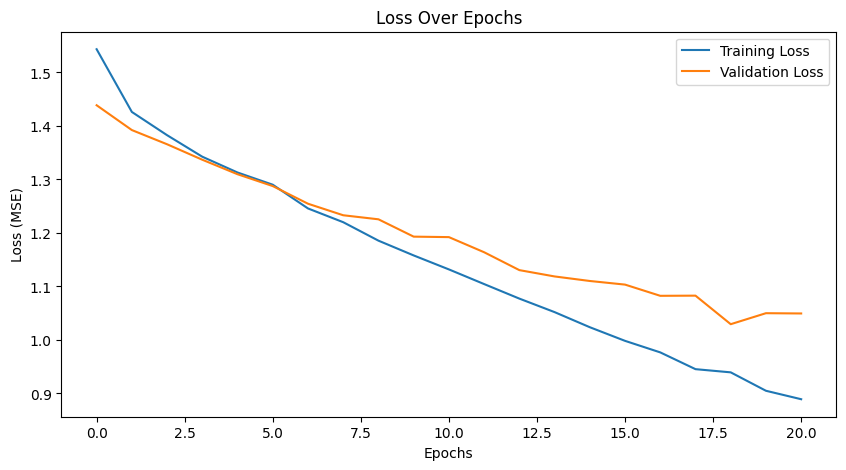

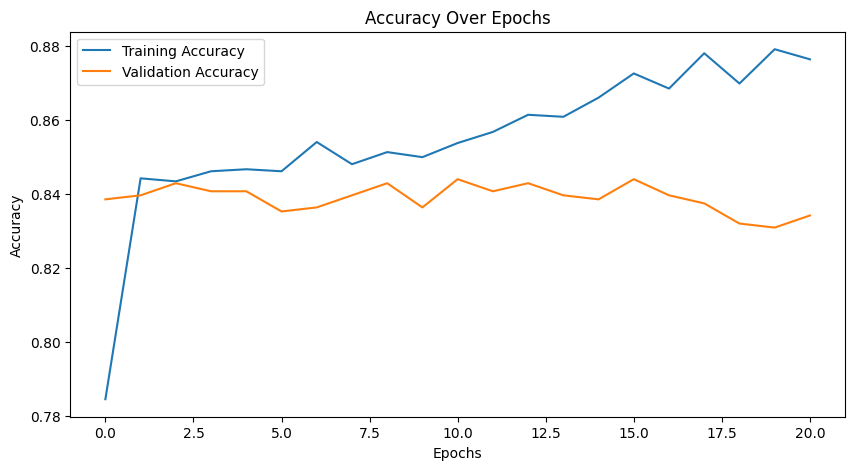

In [ ]:
plot_loss(hist[2])
plot_acc(hist[2])

### Brief Interpretation: Plots

Looking at the graphs, we see that the unregularized model has the lowest value validation loss but the validation loss and accuracy curve are very sporadic. This is a sign of overfitting.

On the other hand, the validation loss curve for the neural network with the L1 regularizer appears to be much smoother despite having a higher loss value. The overfitting is not as severe for the L1 regularizer curve.

It's the same with the Elastic net curve. Since its validation accuracy is lower, we shall use the L1 model with the SGD.

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
              precision    recall  f1-score   support

           0       1.00      0.07      0.13       148
           1       0.85      1.00      0.92       769

    accuracy                           0.85       917
   macro avg       0.92      0.53      0.52       917
weighted avg       0.87      0.85      0.79       917



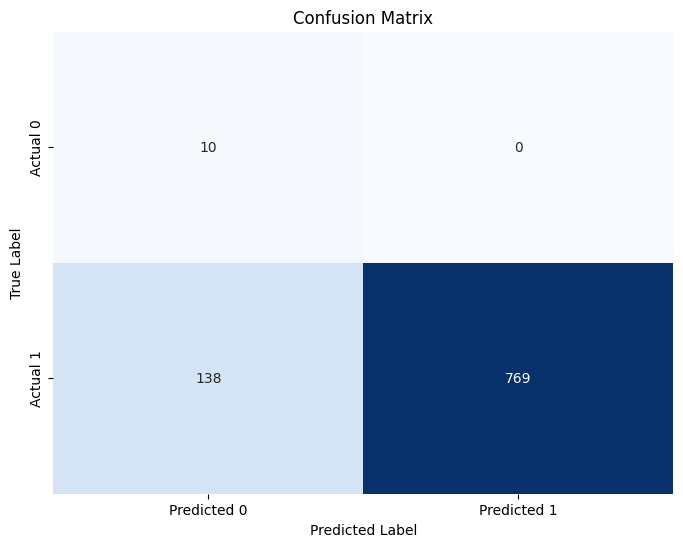

In [ ]:
predictions = model1.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model1.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.8391588 ]
 [0.8799072 ]
 [0.7193606 ]
 ...
 [0.829192  ]
 [0.8640112 ]
 [0.88599163]]
(10, 2)


,count
output,
0.839159,1
0.840294,1
0.835396,1
0.877228,1
0.798228,1
...,...
0.765698,1
0.708005,1
0.861120,1


There aren't a lot of 0 predictions this time. We'll try both the L1 regularizer only and the Elastic Net version.


In [ ]:
#output_df.to_csv('test_predictions_sgd_l1.csv',index=False)

Baseline was .62051.
Test-Acc was .63788. Trying with elastic net.

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
              precision    recall  f1-score   support

           0       0.60      0.10      0.17       148
           1       0.85      0.99      0.91       769

    accuracy                           0.84       917
   macro avg       0.73      0.54      0.54       917
weighted avg       0.81      0.84      0.79       917



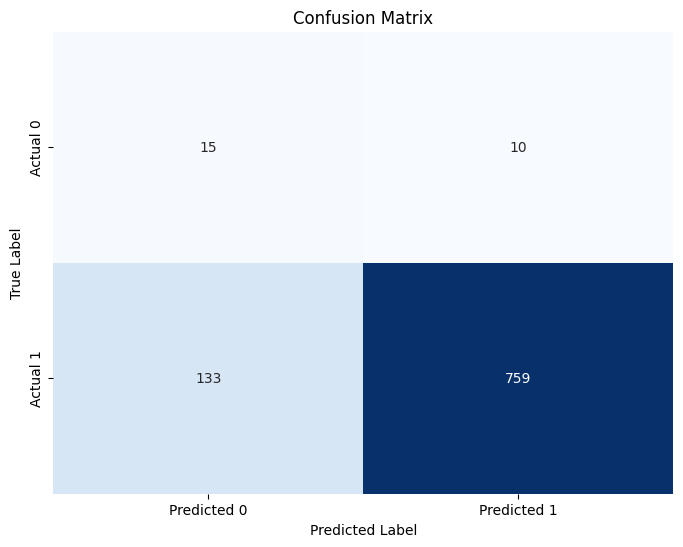

In [ ]:
predictions = model2.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model2.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[0.68456924]
 [0.87969464]
 [0.93107224]
 ...
 [0.95472574]
 [0.87266916]
 [0.92485934]]
(21, 2)


,count
output,
0.684569,1
0.921708,1
0.988831,1
0.974472,1
0.983135,1
...,...
0.811357,1
0.962854,1
0.975334,1


More 0 predictions than the L1 version. It may be doing better

In [ ]:
#output_df.to_csv('test_predictions_sgd_elastic.csv',index=False)

## Leaky Relu

We're going to test the LeakyReLu activation function now. We are also returning to using the Adam optimizer.

In [ ]:
from tensorflow.keras.layers import LeakyReLU
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

### Simple Feedforward Neural Network w/Leaky Relu

Testing a simple feedforward neural network with a single dropout layer and LeakyRelu activation with an alpha of 0.01.

In [ ]:
model = Sequential([
    Dense(64, input_shape=(X_train_transformed.shape[1],)),
    LeakyReLU(alpha=0.01),  # Leaky ReLU activation
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



NameError: name 'Sequential' is not defined

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7822 - loss: 0.5254 - val_accuracy: 0.8353 - val_loss: 0.4240
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8335 - loss: 0.4262 - val_accuracy: 0.8419 - val_loss: 0.4008
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8502 - loss: 0.3779 - val_accuracy: 0.8397 - val_loss: 0.3914
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8557 - loss: 0.3548 - val_accuracy: 0.8397 - val_loss: 0.4005
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8555 - loss: 0.3467 - val_accuracy: 0.8364 - val_loss: 0.4051
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8681 - loss: 0.3160 - val_accuracy: 0.8397 - val_loss: 0.3982
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8714 - loss: 0.3054 - val_accuracy: 0.8332 - val_loss: 0.4076
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8799 - loss: 0.2984 - val_accurac

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.4185 
Validation Loss: 0.4598, Validation Accuracy: 0.8528


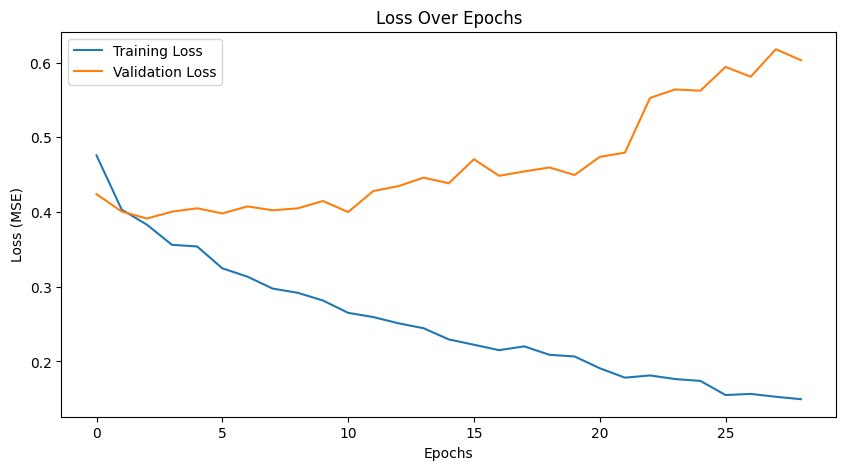

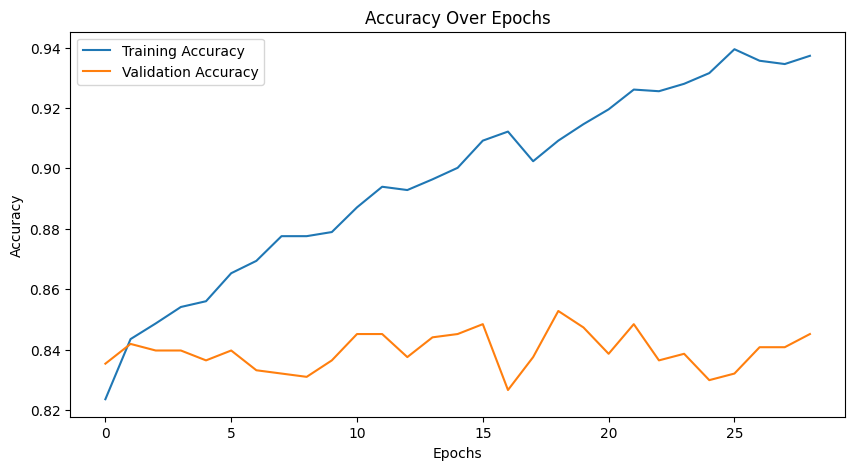

In [ ]:
plot_loss(history)
plot_acc(history)

#### Brief Interpretation: Plots

There is significant evidence of overfitting or there not being enough regularization. The plots are not stable and the loss keeps increasing. Yet we've had one of the highest validation accuracies till now.

We'll continue with further tests on LeakyReLu.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.59      0.29      0.39       148
           1       0.88      0.96      0.92       769

    accuracy                           0.85       917
   macro avg       0.73      0.63      0.65       917
weighted avg       0.83      0.85      0.83       917



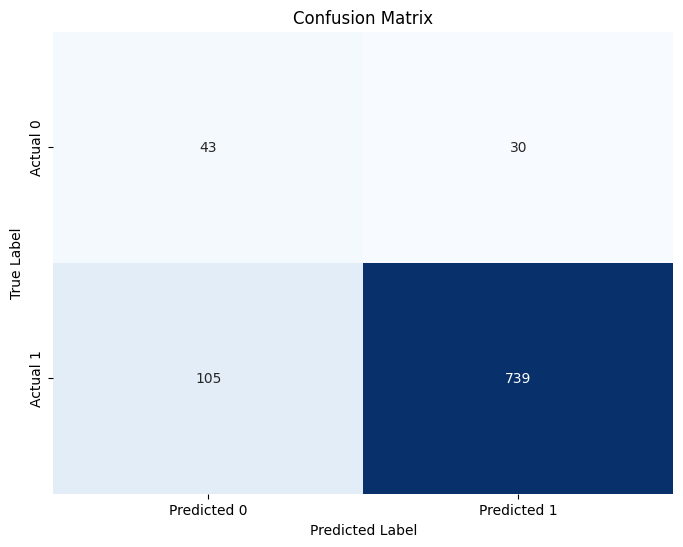

In [ ]:
predictions = model.predict(X_val_transformed)
final_class_labels = (predictions > 0.5).astype(int)
pred = pd.DataFrame(final_class_labels)
pred
cm = confusion_matrix(pred, y_val)

print(classification_report(y_val, pred))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = model.predict(X_test_transformed)
print(test_predictions)
output_df = pd.DataFrame({
     'id': range(0, len(test_predictions)),  # ID column counting from 1
     'output': test_predictions.flatten()  # Flatten predictions to ensure correct shape
 })

output_df.head()
filter = output_df[output_df['output'] < 0.5]
big_filter = output_df[output_df['output']>=0.5]
print(filter.shape)
big_filter.output.value_counts()

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[0.7597365 ]
 [0.99809086]
 [0.7922052 ]
 ...
 [0.8599571 ]
 [0.97510976]
 [0.97931844]]
(105, 2)


,count
output,
1.000000,7
1.000000,2
0.999977,2
0.999997,2
0.999656,2
...,...
0.970188,1
0.939528,1
0.735082,1


Compared to before, there are a lot more guesses in the validation and test data that are closer to 0. This is perhaps an indicator of the improvement in the model because of the new activation function.

In [ ]:
#output_df.to_csv('test_predictions_leaky.csv',index=False)

Highest Test accuracy: Leaky relu with 0.67054.

### Neural Network utilizing Leaky ReLu without a regularizer, L1, and Elastic Net



#### Neural Network with Leaky ReLu and no Regularizer

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

In [ ]:
model = Sequential()


model.add(Dense(256, input_shape=(X_train_transformed.shape[1],)))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5611 - loss: 0.8112 - val_accuracy: 0.8124 - val_loss: 0.4907
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7615 - loss: 0.5197 - val_accuracy: 0.8462 - val_loss: 0.4149
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8250 - loss: 0.4585 - val_accuracy: 0.8495 - val_loss: 0.3976
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8383 - loss: 0.4075 - val_accuracy: 0.8495 - val_loss: 0.3966
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8482 - loss: 0.3872 - val_accuracy: 0.8441 - val_loss: 0.3840
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8356 - loss: 0.3931 - val_accuracy: 0.8484 - val_loss: 0.3804
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8479 - loss: 0.3640 - val_accuracy: 0.8495 - val_loss: 0.3766
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8543 - loss: 0.3564 - val_accur

This is the best validation accuracy to date. But unfortunately, there is no more room for submissions. We shall instead only look at the confusion matrix for this model, the "best" model.

We are going to make a list to contain all the histories that from each model and evaluate them.

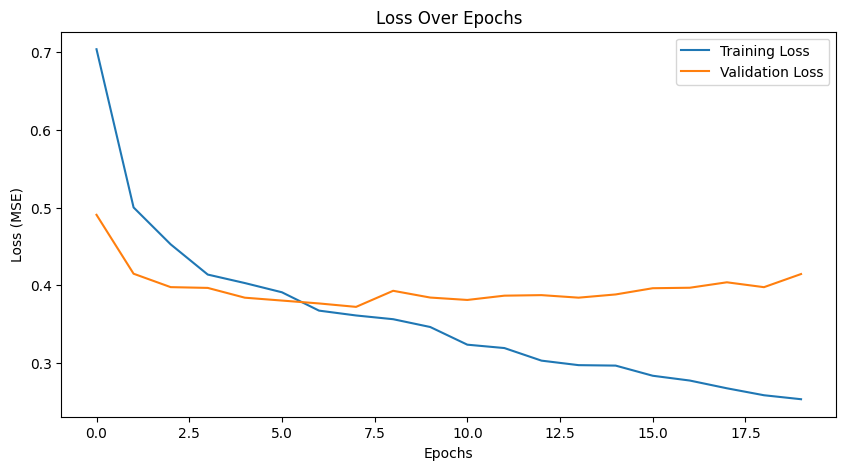

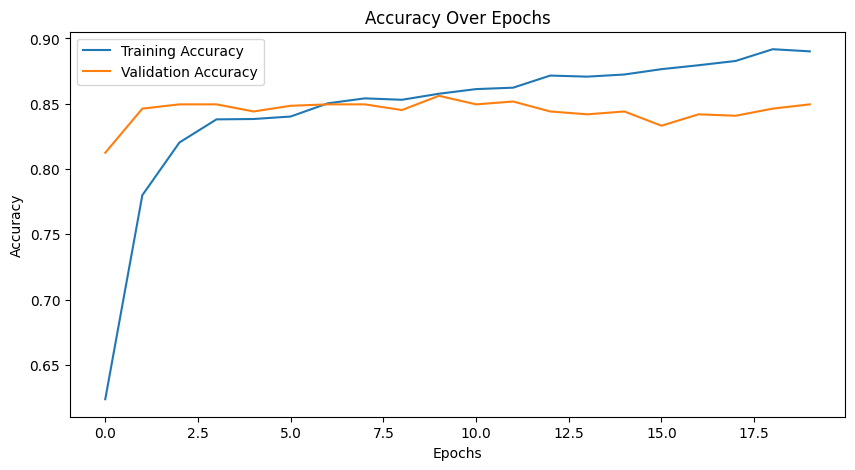

In [ ]:
historia = []

plot_loss(history)
plot_acc(history)

historia.append(history)

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

#### Neural Network with Leaky ReLu and L1 regularizer
We will now execute the model with Leaky Relu and L1 regularization.

In [ ]:
model1 = Sequential()

model1.add(Dense(256, input_shape=(X_train_transformed.shape[1],), kernel_regularizer=l1(1e-4)))  # L1 Regularization
model1.add(LeakyReLU(alpha=0.01))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Dense(128, kernel_regularizer=l1(1e-4)))
model1.add(LeakyReLU(alpha=0.01))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Dense(64, kernel_regularizer=l1(1e-4)))
model1.add(LeakyReLU(alpha=0.01))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(1e-4)))


model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])


model1.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_112              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_113              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_210 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_114              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_211 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

We will now train the Leaky ReLu model with L1 regularization.

In [ ]:
history = model1.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

val_loss, val_accuracy = model1.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 382ms/step - accuracy: 0.5824 - loss: 1.6801 - val_accuracy: 0.8310 - val_loss: 1.3033
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7634 - loss: 1.3418 - val_accuracy: 0.8441 - val_loss: 1.2128
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8363 - loss: 1.2255 - val_accuracy: 0.8473 - val_loss: 1.1653
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8304 - loss: 1.1836 - val_accuracy: 0.8473 - val_loss: 1.1251
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8372 - loss: 1.1181 - val_accuracy: 0.8419 - val_loss: 1.0896
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8464 - loss: 1.0709 - val_accuracy: 0.8495 - val_loss: 1.0451
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8383 - loss: 1.0323 - val_accuracy: 0.8473 - val_loss: 0.9948
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8627 - loss: 0.9626 - val_ac

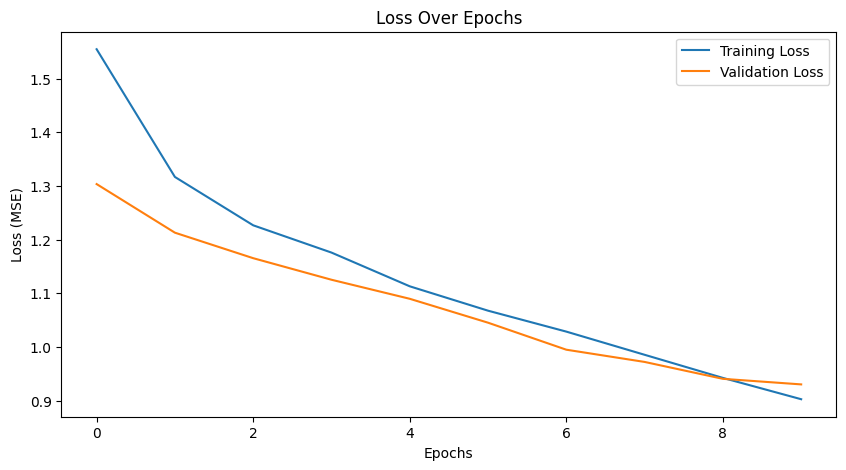

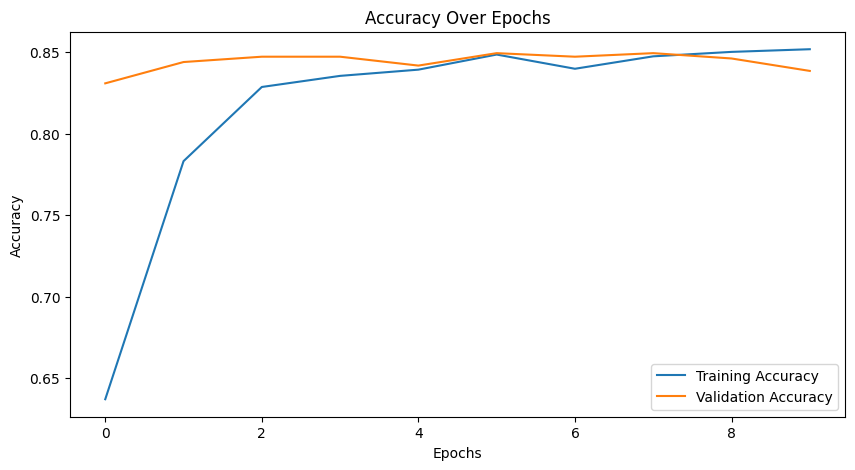

In [ ]:
plot_loss(history)
plot_acc(history)

historia.append(history)

#### Neural Network with Leaky ReLu and Elastic Net Regularizer

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed = preprocess(num, s, phase, bin, X, y, test)

In [ ]:
model2 = Sequential()

model2.add(Dense(256, input_shape=(X_train_transformed.shape[1],), kernel_regularizer=l1_l2(1e-4)))  # Elastic net
model2.add(LeakyReLU(alpha=0.01))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))


model2.add(Dense(128, kernel_regularizer=l1_l2(1e-4)))
model2.add(LeakyReLU(alpha=0.01))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(64, kernel_regularizer=l1_l2(1e-4)))
model2.add(LeakyReLU(alpha=0.01))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(1e-4)))


model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])


model2.summary()

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)                    │ (None, 256)                 │         175,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_115              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_213 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_116              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_214 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_117              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_215 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,369 (853.00 KB)

 Trainable params: 217,473 (849.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model2.fit(X_train_transformed, y_train,
                    validation_data=(X_val_transformed, y_val),
                    epochs=40, batch_size=32, verbose=1, callbacks=[es])

val_loss, val_accuracy = model2.evaluate(X_val_transformed, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5899 - loss: 1.7067 - val_accuracy: 0.8255 - val_loss: 1.3153
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7597 - loss: 1.3519 - val_accuracy: 0.8462 - val_loss: 1.2337
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8300 - loss: 1.2468 - val_accuracy: 0.8473 - val_loss: 1.2003
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8337 - loss: 1.1977 - val_accuracy: 0.8430 - val_loss: 1.1644
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8290 - loss: 1.1566 - val_accuracy: 0.8419 - val_loss: 1.1134
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8464 - loss: 1.1117 - val_accuracy: 0.8473 - val_loss: 1.0810
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8341 - loss: 1.0878 - val_accuracy: 0.8451 - val_loss: 1.0531
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8455 - loss: 1.0292 - val_acc

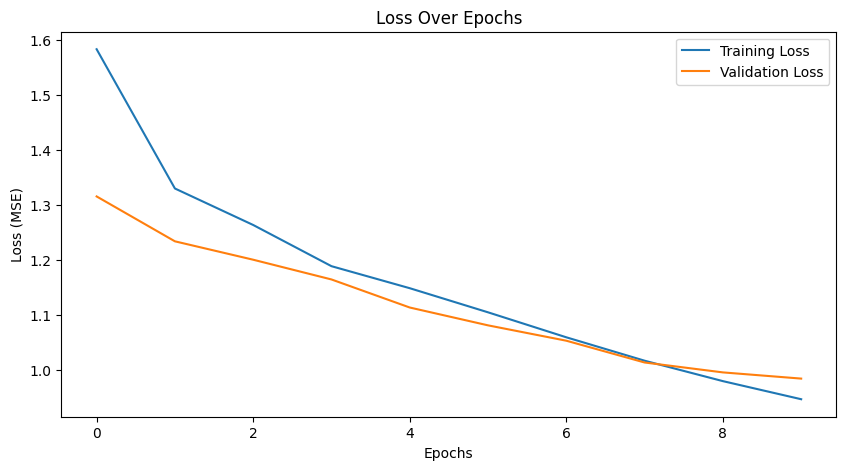

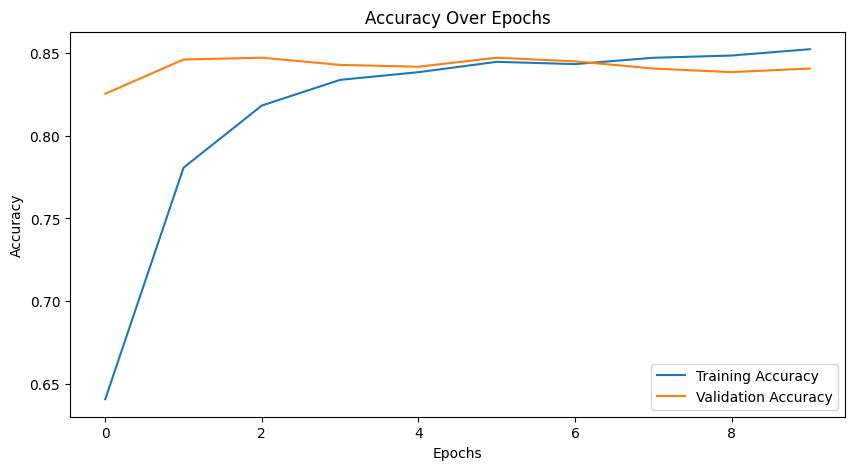

In [ ]:
plot_loss(history)
plot_acc(history)
historia.append(history)

Let's revisit the plots from these last 3 models.

Model 0


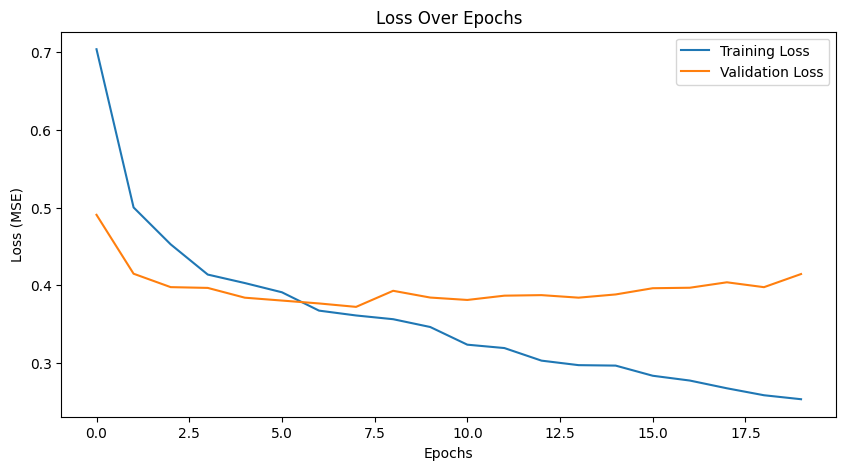

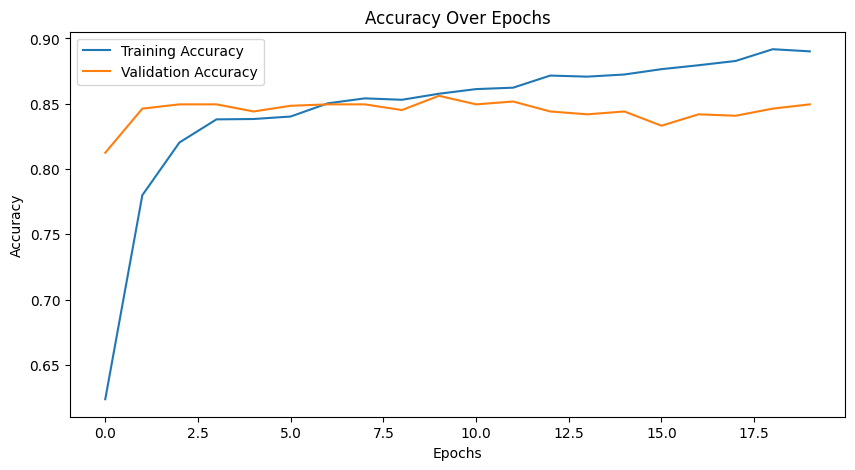

Model 1


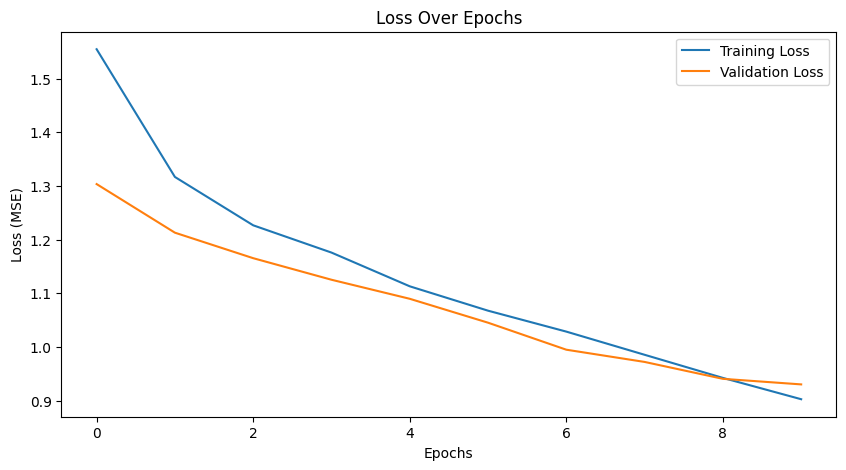

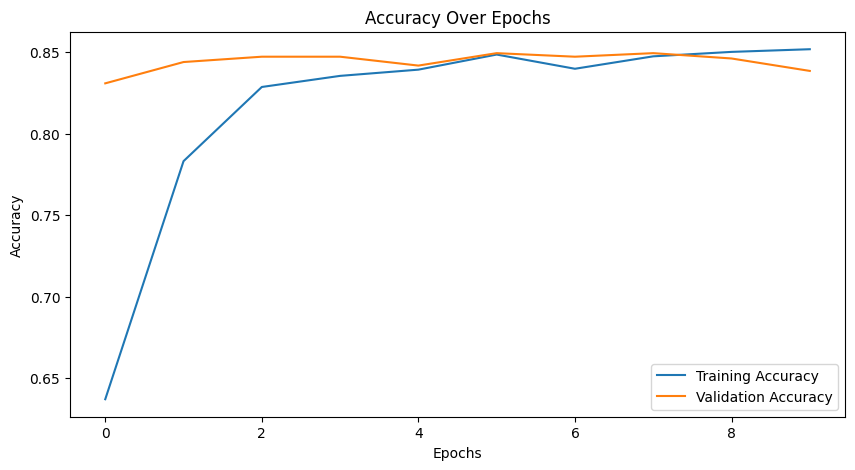

Model 2


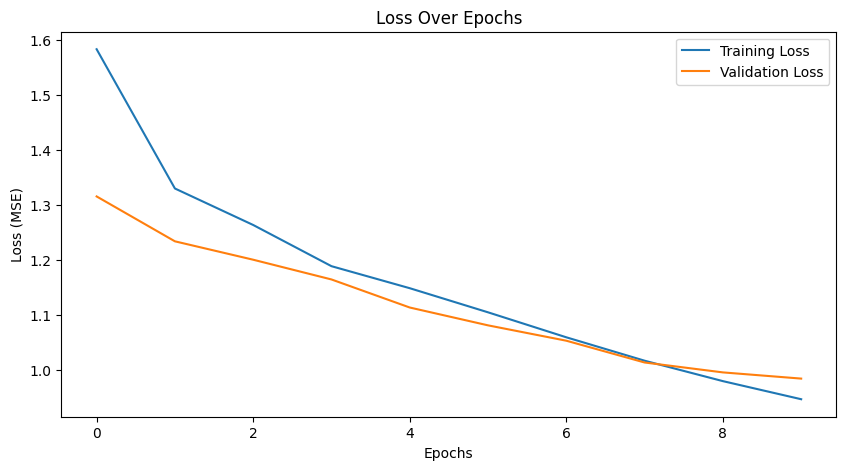

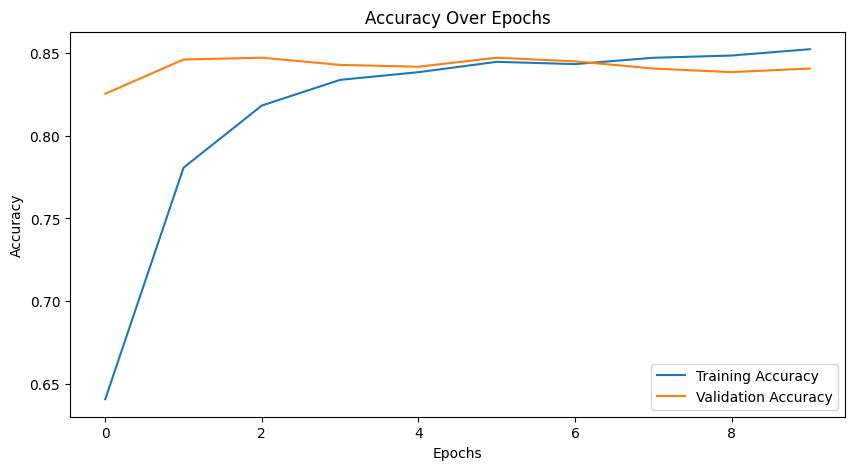

In [ ]:
x= 0
for history in historia:
  print(f"Model {x}")
  plot_loss(history)
  plot_acc(history)

  x+=1

#### Brief Interpretation: Plots

Both the plots for the L1 with the Leaky ReLu and the Elastic Net with Leaky ReLu show signs of convergence. This may mean that the model is learning well and fitting well - however, there isn't much learning going on as the accuracy was naturally high. Yet, the loss does decrease noticeably for both plots.

On the other hand, learning isn't so stable for the unregularized plot. The validation loss starts to increase and the validation accuracy is unstable for the unregularized plot but it does possess the highest tested validation accuracy. Let's look at the confusion matrix.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8683 - loss: 0.3585
Validation Loss: 0.3842155635356903
Validation Accuracy: 0.8560523390769958
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.64      0.24      0.35       148
           1       0.87      0.97      0.92       769

    accuracy                           0.86       917
   macro avg       0.76      0.61      0.64       917
weighted avg       0.83      0.86      0.83       917



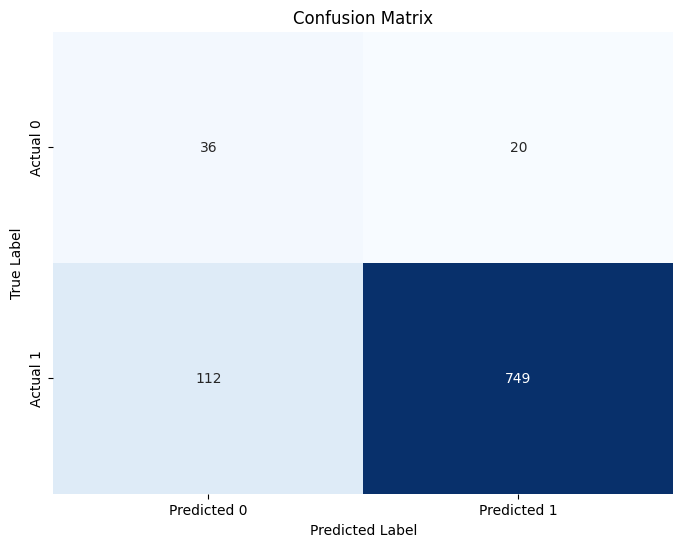

In [ ]:
val_report(model, X_val_transformed, y_val)
confusion_graph(model, X_val_transformed, y_val)

With a val accuracy of about 0.856, it has done the best of all the models till now. In addition, they've increased how many times they've actually guessed 0 so the model has improved in some ways compared to the models without LeakyReLu.

Testing with old Dropout+Batch Normalization model from above using X_train2 and X_val2